In [10]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.colors as mcolors 
from IPython.display import HTML
import os
%load_ext line_profiler
%matplotlib inline

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [18]:
def checkIfExistsAndCreateIfNeeded(myPath):
    if (not os.path.exists(myPath)):
        os.mkdir(myPath)

In [19]:
def defineBactGeometry(a=1.3e-6, ls=0, wRel=100*2*np.pi, nbSteps=1000, xi=-1, n=4, l=15e-6,  alpha=41, aHelix=240e-9, lambdaHelix=3e-6, mu=1e-3):
    #helix parameters
    #xi = -1 #right or left handedness. Bacteria have xi=-1
    #n = 4 #nb of turns
    #l = 15e-6 #contour length, in um
    #ls = 1.5e-6 #characterestic length 
    #alpha = 41 #helic pitch angle, in degrees
    #zetaRatio = 2
    #aHelix = 240e-9
    #lambdaHelix = 3e-6
    #wRel = 100 *2*np.pi#rotation rate

    #mu = 1e-3 #fluid viscosity
    #a = 1.3e-6 #head radius

    #convert alpha to radians
    alpha = alpha * np.pi/180

    R = np.sin(alpha)*l/(2.*np.pi*n) #helix radius
    sStep = l/nbSteps 
    s = np.linspace(-l/2, l/2, num=nbSteps)

    minS = np.amin(s)
    
    if (ls==0):
        rHelix = np.array([[R*np.cos(2.*np.pi*xi*n*s/l)], [R*np.sin(2.*np.pi*xi*n*s/l)], [s*np.cos(alpha)]])
        tHelix = np.array([[-np.sin(alpha)*xi*np.sin(2.*np.pi*xi*n*s/l)], 
                            [np.sin(alpha)*xi*np.cos(2.*np.pi*xi*n*s/l)],
                            [np.ones_like(s)*np.cos(alpha)]])

        #vdHelix = np.array([[-R*wRel*np.sin(2.*np.pi*xi*n*s/l)],[R*wRel*np.cos(2.*np.pi*xi*n*s/l)], [np.zeros_like(s)]])
        vdHelix = R*wRel*tHelix

        
    else:
        rHelix = np.array([R*np.cos(2.*np.pi*xi*n*s/l)*(1-np.exp(-(s-minS)/ls)), R*np.sin(2.*np.pi*xi*n*s/l)*(1-np.exp(-(s-minS)/ls)), s*np.cos(alpha)])
        tHelix = np.array([-np.sin(alpha)*xi*np.sin(2.*np.pi*xi*n*s/l)*(1-np.exp(-(s-minS)/ls)) + 1/ls*np.exp(-(s-minS)/ls)*R*np.cos(2.*np.pi*xi*n*s/l), 
                           np.sin(alpha)*xi*np.cos(2.*np.pi*xi*n*s/l)*(1-np.exp(-(s-minS)/ls)) + 1/ls*np.exp(-(s-minS)/ls)*R*np.sin(2.*np.pi*xi*n*s/l),
                           np.ones_like(s)*np.cos(alpha)])

        magTHelix = np.sqrt(np.sum(tHelix**2,axis = 0))
        tHelix = tHelix/magTHelix #normalize the tangent vector

        #vdHelix = np.array([-R*wRel*np.sin(2.*np.pi*xi*n*s/l)*(1-np.exp(-(s-minS)/ls)), R*wRel*np.cos(2.*np.pi*xi*n*s/l)*(1-np.exp(-(s-minS)/ls)), np.zeros_like(s)])
        vdHelix = R*wRel*tHelix
    
    #flatten the arrays
    rHelix = np.squeeze(rHelix)
    tHelix = np.squeeze(tHelix)
    vdHelix = np.squeeze(vdHelix)
    
    
    deltaRHead = xi*np.array([0, 0, -a]) #vector from center of head to end of Helix
    deltaRHelix = xi*np.array([0, 0, l/2*np.cos(alpha)]) #vector from center of helix to end of helix

    zetaPara = 4*np.pi*mu/(math.log(4*lambdaHelix**2/aHelix**2)-1)

    
    
    return(rHelix, tHelix, vdHelix, deltaRHead, deltaRHelix, zetaPara, sStep)

In [20]:
def eulerRotate(theta, psi, phi, matToRotate):
    
    Ttheta = np.array([[np.cos(theta), np.sin(theta), 0],
            [-np.sin(theta), np.cos(theta), 0],
            [0, 0, 1]])

    Tpsi = np.array([[np.cos(psi), 0, -np.sin(psi)],
            [0, 1, 0],
           [np.sin(psi), 0, np.cos(psi)]])

    Tphi = np.array([[np.cos(phi), np.sin(phi), 0],
            [-np.sin(phi), np.cos(phi), 0],
            [0, 0, 1]])
    
#     Tphi = np.array([[1, 0, 0],
#             [0, np.cos(phi), np.sin(phi)],
#             [0, -np.sin(phi), np.cos(phi)]])


    
    TEuler = np.matmul(Tpsi,Ttheta)
    TEuler = np.matmul(Tphi,TEuler)
    rotatedMat = np.matmul(TEuler.T,matToRotate)
    
    return(rotatedMat)

In [21]:
def bactSpeed(zetaPara, zetaRatio, Vfluid, tHelix, rHelix, deltaRHelix, deltaRHead, vfluidAtHead, curlAtHead, vdHelix, a, mu, sStep):

    Vfx = Vfluid[0,:]
    Vfy = Vfluid[1,:]
    Vfz = Vfluid[2,:]
    
    tx = tHelix[0,:]
    ty = tHelix[1,:]
    tz = tHelix[2,:]
     
    deltaRHelixx = deltaRHelix[0]
    deltaRHelixy = deltaRHelix[1]
    deltaRHelixz = deltaRHelix[2]
    
    deltaRHeadx = deltaRHead[0]
    deltaRHeady = deltaRHead[1]
    deltaRHeadz = deltaRHead[2]
    
  
    rHelixx = rHelix[0,:]
    rHelixy = rHelix[1,:]
    rHelixz = rHelix[2,:]
    
    vdHelixx = vdHelix[0,:]
    vdHelixy = vdHelix[1,:]
    vdHelixz = vdHelix[2,:]
    
    vxAtHead = vfluidAtHead[0]
    vyAtHead = vfluidAtHead[1]
    vzAtHead = vfluidAtHead[2]
    
    omegaxAtHead = curlAtHead[0]
    omegayAtHead = curlAtHead[1]
    omegazAtHead = curlAtHead[2]
    
    
    
    zetaMatHelix = sStep*np.array([
    [                                                                                                                                                                                                                                                                                                                                                                                                                                            np.sum(tx**2*zetaPara*zetaRatio - tx**2*zetaPara - zetaPara*zetaRatio),                                                                                                                                                                                                                                                                                                                                                                                                                                                                 np.sum(tx*ty*zetaPara*zetaRatio - tx*ty*zetaPara),                                                                                                                                                                                                                                                                                                                                                                                                                                                                  np.sum(tx*tz*zetaPara*zetaRatio - tx*tz*zetaPara),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             np.sum(deltaRHeady*tx*tz*zetaPara*zetaRatio - deltaRHeady*tx*tz*zetaPara - deltaRHeadz*tx*ty*zetaPara*zetaRatio + deltaRHeadz*tx*ty*zetaPara - deltaRHelixy*tx*tz*zetaPara*zetaRatio + deltaRHelixy*tx*tz*zetaPara + deltaRHelixz*tx*ty*zetaPara*zetaRatio - deltaRHelixz*tx*ty*zetaPara + rHelixy*tx*tz*zetaPara*zetaRatio - rHelixy*tx*tz*zetaPara - rHelixz*tx*ty*zetaPara*zetaRatio + rHelixz*tx*ty*zetaPara),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            np.sum(-deltaRHeadx*tx*tz*zetaPara*zetaRatio + deltaRHeadx*tx*tz*zetaPara + deltaRHeadz*tx**2*zetaPara*zetaRatio - deltaRHeadz*tx**2*zetaPara - deltaRHeadz*zetaPara*zetaRatio + deltaRHelixx*tx*tz*zetaPara*zetaRatio - deltaRHelixx*tx*tz*zetaPara - deltaRHelixz*tx**2*zetaPara*zetaRatio + deltaRHelixz*tx**2*zetaPara + deltaRHelixz*zetaPara*zetaRatio - rHelixx*tx*tz*zetaPara*zetaRatio + rHelixx*tx*tz*zetaPara + rHelixz*tx**2*zetaPara*zetaRatio - rHelixz*tx**2*zetaPara - rHelixz*zetaPara*zetaRatio),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             np.sum(deltaRHeadx*tx*ty*zetaPara*zetaRatio - deltaRHeadx*tx*ty*zetaPara - deltaRHeady*tx**2*zetaPara*zetaRatio + deltaRHeady*tx**2*zetaPara + deltaRHeady*zetaPara*zetaRatio - deltaRHelixx*tx*ty*zetaPara*zetaRatio + deltaRHelixx*tx*ty*zetaPara + deltaRHelixy*tx**2*zetaPara*zetaRatio - deltaRHelixy*tx**2*zetaPara - deltaRHelixy*zetaPara*zetaRatio + rHelixx*tx*ty*zetaPara*zetaRatio - rHelixx*tx*ty*zetaPara - rHelixy*tx**2*zetaPara*zetaRatio + rHelixy*tx**2*zetaPara + rHelixy*zetaPara*zetaRatio)],
    [                                                                                                                                                                                                                                                                                                                                                                                                                                                                 np.sum(tx*ty*zetaPara*zetaRatio - tx*ty*zetaPara),                                                                                                                                                                                                                                                                                                                                                                                                                                            np.sum(ty**2*zetaPara*zetaRatio - ty**2*zetaPara - zetaPara*zetaRatio),                                                                                                                                                                                                                                                                                                                                                                                                                                                                  np.sum(ty*tz*zetaPara*zetaRatio - ty*tz*zetaPara),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             np.sum(deltaRHeady*ty*tz*zetaPara*zetaRatio - deltaRHeady*ty*tz*zetaPara - deltaRHeadz*ty**2*zetaPara*zetaRatio + deltaRHeadz*ty**2*zetaPara + deltaRHeadz*zetaPara*zetaRatio - deltaRHelixy*ty*tz*zetaPara*zetaRatio + deltaRHelixy*ty*tz*zetaPara + deltaRHelixz*ty**2*zetaPara*zetaRatio - deltaRHelixz*ty**2*zetaPara - deltaRHelixz*zetaPara*zetaRatio + rHelixy*ty*tz*zetaPara*zetaRatio - rHelixy*ty*tz*zetaPara - rHelixz*ty**2*zetaPara*zetaRatio + rHelixz*ty**2*zetaPara + rHelixz*zetaPara*zetaRatio),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            np.sum(-deltaRHeadx*ty*tz*zetaPara*zetaRatio + deltaRHeadx*ty*tz*zetaPara + deltaRHeadz*tx*ty*zetaPara*zetaRatio - deltaRHeadz*tx*ty*zetaPara + deltaRHelixx*ty*tz*zetaPara*zetaRatio - deltaRHelixx*ty*tz*zetaPara - deltaRHelixz*tx*ty*zetaPara*zetaRatio + deltaRHelixz*tx*ty*zetaPara - rHelixx*ty*tz*zetaPara*zetaRatio + rHelixx*ty*tz*zetaPara + rHelixz*tx*ty*zetaPara*zetaRatio - rHelixz*tx*ty*zetaPara),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             np.sum(deltaRHeadx*ty**2*zetaPara*zetaRatio - deltaRHeadx*ty**2*zetaPara - deltaRHeadx*zetaPara*zetaRatio - deltaRHeady*tx*ty*zetaPara*zetaRatio + deltaRHeady*tx*ty*zetaPara - deltaRHelixx*ty**2*zetaPara*zetaRatio + deltaRHelixx*ty**2*zetaPara + deltaRHelixx*zetaPara*zetaRatio + deltaRHelixy*tx*ty*zetaPara*zetaRatio - deltaRHelixy*tx*ty*zetaPara + rHelixx*ty**2*zetaPara*zetaRatio - rHelixx*ty**2*zetaPara - rHelixx*zetaPara*zetaRatio - rHelixy*tx*ty*zetaPara*zetaRatio + rHelixy*tx*ty*zetaPara)],
    [                                                                                                                                                                                                                                                                                                                                                                                                                                                                 np.sum(tx*tz*zetaPara*zetaRatio - tx*tz*zetaPara),                                                                                                                                                                                                                                                                                                                                                                                                                                                                 np.sum(ty*tz*zetaPara*zetaRatio - ty*tz*zetaPara),                                                                                                                                                                                                                                                                                                                                                                                                                                             np.sum(tz**2*zetaPara*zetaRatio - tz**2*zetaPara - zetaPara*zetaRatio),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             np.sum(deltaRHeady*tz**2*zetaPara*zetaRatio - deltaRHeady*tz**2*zetaPara - deltaRHeady*zetaPara*zetaRatio - deltaRHeadz*ty*tz*zetaPara*zetaRatio + deltaRHeadz*ty*tz*zetaPara - deltaRHelixy*tz**2*zetaPara*zetaRatio + deltaRHelixy*tz**2*zetaPara + deltaRHelixy*zetaPara*zetaRatio + deltaRHelixz*ty*tz*zetaPara*zetaRatio - deltaRHelixz*ty*tz*zetaPara + rHelixy*tz**2*zetaPara*zetaRatio - rHelixy*tz**2*zetaPara - rHelixy*zetaPara*zetaRatio - rHelixz*ty*tz*zetaPara*zetaRatio + rHelixz*ty*tz*zetaPara),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            np.sum(-deltaRHeadx*tz**2*zetaPara*zetaRatio + deltaRHeadx*tz**2*zetaPara + deltaRHeadx*zetaPara*zetaRatio + deltaRHeadz*tx*tz*zetaPara*zetaRatio - deltaRHeadz*tx*tz*zetaPara + deltaRHelixx*tz**2*zetaPara*zetaRatio - deltaRHelixx*tz**2*zetaPara - deltaRHelixx*zetaPara*zetaRatio - deltaRHelixz*tx*tz*zetaPara*zetaRatio + deltaRHelixz*tx*tz*zetaPara - rHelixx*tz**2*zetaPara*zetaRatio + rHelixx*tz**2*zetaPara + rHelixx*zetaPara*zetaRatio + rHelixz*tx*tz*zetaPara*zetaRatio - rHelixz*tx*tz*zetaPara),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             np.sum(deltaRHeadx*ty*tz*zetaPara*zetaRatio - deltaRHeadx*ty*tz*zetaPara - deltaRHeady*tx*tz*zetaPara*zetaRatio + deltaRHeady*tx*tz*zetaPara - deltaRHelixx*ty*tz*zetaPara*zetaRatio + deltaRHelixx*ty*tz*zetaPara + deltaRHelixy*tx*tz*zetaPara*zetaRatio - deltaRHelixy*tx*tz*zetaPara + rHelixx*ty*tz*zetaPara*zetaRatio - rHelixx*ty*tz*zetaPara - rHelixy*tx*tz*zetaPara*zetaRatio + rHelixy*tx*tz*zetaPara)],
    [                                                                                                 np.sum(deltaRHeady*tx*tz*zetaPara*zetaRatio - deltaRHeady*tx*tz*zetaPara - deltaRHeadz*tx*ty*zetaPara*zetaRatio + deltaRHeadz*tx*ty*zetaPara - deltaRHelixy*tx*tz*zetaPara*zetaRatio + deltaRHelixy*tx*tz*zetaPara + deltaRHelixz*tx*ty*zetaPara*zetaRatio - deltaRHelixz*tx*ty*zetaPara + rHelixy*tx*tz*zetaPara*zetaRatio - rHelixy*tx*tz*zetaPara - rHelixz*tx*ty*zetaPara*zetaRatio + rHelixz*tx*ty*zetaPara), np.sum(deltaRHeady*ty*tz*zetaPara*zetaRatio - deltaRHeady*ty*tz*zetaPara - deltaRHeadz*ty**2*zetaPara*zetaRatio + deltaRHeadz*ty**2*zetaPara + deltaRHeadz*zetaPara*zetaRatio - deltaRHelixy*ty*tz*zetaPara*zetaRatio + deltaRHelixy*ty*tz*zetaPara + deltaRHelixz*ty**2*zetaPara*zetaRatio - deltaRHelixz*ty**2*zetaPara - deltaRHelixz*zetaPara*zetaRatio + rHelixy*ty*tz*zetaPara*zetaRatio - rHelixy*ty*tz*zetaPara - rHelixz*ty**2*zetaPara*zetaRatio + rHelixz*ty**2*zetaPara + rHelixz*zetaPara*zetaRatio),  np.sum(deltaRHeady*tz**2*zetaPara*zetaRatio - deltaRHeady*tz**2*zetaPara - deltaRHeady*zetaPara*zetaRatio - deltaRHeadz*ty*tz*zetaPara*zetaRatio + deltaRHeadz*ty*tz*zetaPara - deltaRHelixy*tz**2*zetaPara*zetaRatio + deltaRHelixy*tz**2*zetaPara + deltaRHelixy*zetaPara*zetaRatio + deltaRHelixz*ty*tz*zetaPara*zetaRatio - deltaRHelixz*ty*tz*zetaPara + rHelixy*tz**2*zetaPara*zetaRatio - rHelixy*tz**2*zetaPara - rHelixy*zetaPara*zetaRatio - rHelixz*ty*tz*zetaPara*zetaRatio + rHelixz*ty*tz*zetaPara),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     np.sum(deltaRHeady**2*tz**2*zetaPara*zetaRatio - deltaRHeady**2*tz**2*zetaPara - deltaRHeady**2*zetaPara*zetaRatio - 2*deltaRHeady*deltaRHeadz*ty*tz*zetaPara*zetaRatio + 2*deltaRHeady*deltaRHeadz*ty*tz*zetaPara - 2*deltaRHeady*deltaRHelixy*tz**2*zetaPara*zetaRatio + 2*deltaRHeady*deltaRHelixy*tz**2*zetaPara + 2*deltaRHeady*deltaRHelixy*zetaPara*zetaRatio + 2*deltaRHeady*deltaRHelixz*ty*tz*zetaPara*zetaRatio - 2*deltaRHeady*deltaRHelixz*ty*tz*zetaPara + 2*deltaRHeady*rHelixy*tz**2*zetaPara*zetaRatio - 2*deltaRHeady*rHelixy*tz**2*zetaPara - 2*deltaRHeady*rHelixy*zetaPara*zetaRatio - 2*deltaRHeady*rHelixz*ty*tz*zetaPara*zetaRatio + 2*deltaRHeady*rHelixz*ty*tz*zetaPara + deltaRHeadz**2*ty**2*zetaPara*zetaRatio - deltaRHeadz**2*ty**2*zetaPara - deltaRHeadz**2*zetaPara*zetaRatio + 2*deltaRHeadz*deltaRHelixy*ty*tz*zetaPara*zetaRatio - 2*deltaRHeadz*deltaRHelixy*ty*tz*zetaPara - 2*deltaRHeadz*deltaRHelixz*ty**2*zetaPara*zetaRatio + 2*deltaRHeadz*deltaRHelixz*ty**2*zetaPara + 2*deltaRHeadz*deltaRHelixz*zetaPara*zetaRatio - 2*deltaRHeadz*rHelixy*ty*tz*zetaPara*zetaRatio + 2*deltaRHeadz*rHelixy*ty*tz*zetaPara + 2*deltaRHeadz*rHelixz*ty**2*zetaPara*zetaRatio - 2*deltaRHeadz*rHelixz*ty**2*zetaPara - 2*deltaRHeadz*rHelixz*zetaPara*zetaRatio + deltaRHelixy**2*tz**2*zetaPara*zetaRatio - deltaRHelixy**2*tz**2*zetaPara - deltaRHelixy**2*zetaPara*zetaRatio - 2*deltaRHelixy*deltaRHelixz*ty*tz*zetaPara*zetaRatio + 2*deltaRHelixy*deltaRHelixz*ty*tz*zetaPara - 2*deltaRHelixy*rHelixy*tz**2*zetaPara*zetaRatio + 2*deltaRHelixy*rHelixy*tz**2*zetaPara + 2*deltaRHelixy*rHelixy*zetaPara*zetaRatio + 2*deltaRHelixy*rHelixz*ty*tz*zetaPara*zetaRatio - 2*deltaRHelixy*rHelixz*ty*tz*zetaPara + deltaRHelixz**2*ty**2*zetaPara*zetaRatio - deltaRHelixz**2*ty**2*zetaPara - deltaRHelixz**2*zetaPara*zetaRatio + 2*deltaRHelixz*rHelixy*ty*tz*zetaPara*zetaRatio - 2*deltaRHelixz*rHelixy*ty*tz*zetaPara - 2*deltaRHelixz*rHelixz*ty**2*zetaPara*zetaRatio + 2*deltaRHelixz*rHelixz*ty**2*zetaPara + 2*deltaRHelixz*rHelixz*zetaPara*zetaRatio + rHelixy**2*tz**2*zetaPara*zetaRatio - rHelixy**2*tz**2*zetaPara - rHelixy**2*zetaPara*zetaRatio - 2*rHelixy*rHelixz*ty*tz*zetaPara*zetaRatio + 2*rHelixy*rHelixz*ty*tz*zetaPara + rHelixz**2*ty**2*zetaPara*zetaRatio - rHelixz**2*ty**2*zetaPara - rHelixz**2*zetaPara*zetaRatio), np.sum(-deltaRHeadx*deltaRHeady*tz**2*zetaPara*zetaRatio + deltaRHeadx*deltaRHeady*tz**2*zetaPara + deltaRHeadx*deltaRHeady*zetaPara*zetaRatio + deltaRHeadx*deltaRHeadz*ty*tz*zetaPara*zetaRatio - deltaRHeadx*deltaRHeadz*ty*tz*zetaPara + deltaRHeadx*deltaRHelixy*tz**2*zetaPara*zetaRatio - deltaRHeadx*deltaRHelixy*tz**2*zetaPara - deltaRHeadx*deltaRHelixy*zetaPara*zetaRatio - deltaRHeadx*deltaRHelixz*ty*tz*zetaPara*zetaRatio + deltaRHeadx*deltaRHelixz*ty*tz*zetaPara - deltaRHeadx*rHelixy*tz**2*zetaPara*zetaRatio + deltaRHeadx*rHelixy*tz**2*zetaPara + deltaRHeadx*rHelixy*zetaPara*zetaRatio + deltaRHeadx*rHelixz*ty*tz*zetaPara*zetaRatio - deltaRHeadx*rHelixz*ty*tz*zetaPara + deltaRHeady*deltaRHeadz*tx*tz*zetaPara*zetaRatio - deltaRHeady*deltaRHeadz*tx*tz*zetaPara + deltaRHeady*deltaRHelixx*tz**2*zetaPara*zetaRatio - deltaRHeady*deltaRHelixx*tz**2*zetaPara - deltaRHeady*deltaRHelixx*zetaPara*zetaRatio - deltaRHeady*deltaRHelixz*tx*tz*zetaPara*zetaRatio + deltaRHeady*deltaRHelixz*tx*tz*zetaPara - deltaRHeady*rHelixx*tz**2*zetaPara*zetaRatio + deltaRHeady*rHelixx*tz**2*zetaPara + deltaRHeady*rHelixx*zetaPara*zetaRatio + deltaRHeady*rHelixz*tx*tz*zetaPara*zetaRatio - deltaRHeady*rHelixz*tx*tz*zetaPara - deltaRHeadz**2*tx*ty*zetaPara*zetaRatio + deltaRHeadz**2*tx*ty*zetaPara - deltaRHeadz*deltaRHelixx*ty*tz*zetaPara*zetaRatio + deltaRHeadz*deltaRHelixx*ty*tz*zetaPara - deltaRHeadz*deltaRHelixy*tx*tz*zetaPara*zetaRatio + deltaRHeadz*deltaRHelixy*tx*tz*zetaPara + 2*deltaRHeadz*deltaRHelixz*tx*ty*zetaPara*zetaRatio - 2*deltaRHeadz*deltaRHelixz*tx*ty*zetaPara + deltaRHeadz*rHelixx*ty*tz*zetaPara*zetaRatio - deltaRHeadz*rHelixx*ty*tz*zetaPara + deltaRHeadz*rHelixy*tx*tz*zetaPara*zetaRatio - deltaRHeadz*rHelixy*tx*tz*zetaPara - 2*deltaRHeadz*rHelixz*tx*ty*zetaPara*zetaRatio + 2*deltaRHeadz*rHelixz*tx*ty*zetaPara - deltaRHelixx*deltaRHelixy*tz**2*zetaPara*zetaRatio + deltaRHelixx*deltaRHelixy*tz**2*zetaPara + deltaRHelixx*deltaRHelixy*zetaPara*zetaRatio + deltaRHelixx*deltaRHelixz*ty*tz*zetaPara*zetaRatio - deltaRHelixx*deltaRHelixz*ty*tz*zetaPara + deltaRHelixx*rHelixy*tz**2*zetaPara*zetaRatio - deltaRHelixx*rHelixy*tz**2*zetaPara - deltaRHelixx*rHelixy*zetaPara*zetaRatio - deltaRHelixx*rHelixz*ty*tz*zetaPara*zetaRatio + deltaRHelixx*rHelixz*ty*tz*zetaPara + deltaRHelixy*deltaRHelixz*tx*tz*zetaPara*zetaRatio - deltaRHelixy*deltaRHelixz*tx*tz*zetaPara + deltaRHelixy*rHelixx*tz**2*zetaPara*zetaRatio - deltaRHelixy*rHelixx*tz**2*zetaPara - deltaRHelixy*rHelixx*zetaPara*zetaRatio - deltaRHelixy*rHelixz*tx*tz*zetaPara*zetaRatio + deltaRHelixy*rHelixz*tx*tz*zetaPara - deltaRHelixz**2*tx*ty*zetaPara*zetaRatio + deltaRHelixz**2*tx*ty*zetaPara - deltaRHelixz*rHelixx*ty*tz*zetaPara*zetaRatio + deltaRHelixz*rHelixx*ty*tz*zetaPara - deltaRHelixz*rHelixy*tx*tz*zetaPara*zetaRatio + deltaRHelixz*rHelixy*tx*tz*zetaPara + 2*deltaRHelixz*rHelixz*tx*ty*zetaPara*zetaRatio - 2*deltaRHelixz*rHelixz*tx*ty*zetaPara - rHelixx*rHelixy*tz**2*zetaPara*zetaRatio + rHelixx*rHelixy*tz**2*zetaPara + rHelixx*rHelixy*zetaPara*zetaRatio + rHelixx*rHelixz*ty*tz*zetaPara*zetaRatio - rHelixx*rHelixz*ty*tz*zetaPara + rHelixy*rHelixz*tx*tz*zetaPara*zetaRatio - rHelixy*rHelixz*tx*tz*zetaPara - rHelixz**2*tx*ty*zetaPara*zetaRatio + rHelixz**2*tx*ty*zetaPara),  np.sum(deltaRHeadx*deltaRHeady*ty*tz*zetaPara*zetaRatio - deltaRHeadx*deltaRHeady*ty*tz*zetaPara - deltaRHeadx*deltaRHeadz*ty**2*zetaPara*zetaRatio + deltaRHeadx*deltaRHeadz*ty**2*zetaPara + deltaRHeadx*deltaRHeadz*zetaPara*zetaRatio - deltaRHeadx*deltaRHelixy*ty*tz*zetaPara*zetaRatio + deltaRHeadx*deltaRHelixy*ty*tz*zetaPara + deltaRHeadx*deltaRHelixz*ty**2*zetaPara*zetaRatio - deltaRHeadx*deltaRHelixz*ty**2*zetaPara - deltaRHeadx*deltaRHelixz*zetaPara*zetaRatio + deltaRHeadx*rHelixy*ty*tz*zetaPara*zetaRatio - deltaRHeadx*rHelixy*ty*tz*zetaPara - deltaRHeadx*rHelixz*ty**2*zetaPara*zetaRatio + deltaRHeadx*rHelixz*ty**2*zetaPara + deltaRHeadx*rHelixz*zetaPara*zetaRatio - deltaRHeady**2*tx*tz*zetaPara*zetaRatio + deltaRHeady**2*tx*tz*zetaPara + deltaRHeady*deltaRHeadz*tx*ty*zetaPara*zetaRatio - deltaRHeady*deltaRHeadz*tx*ty*zetaPara - deltaRHeady*deltaRHelixx*ty*tz*zetaPara*zetaRatio + deltaRHeady*deltaRHelixx*ty*tz*zetaPara + 2*deltaRHeady*deltaRHelixy*tx*tz*zetaPara*zetaRatio - 2*deltaRHeady*deltaRHelixy*tx*tz*zetaPara - deltaRHeady*deltaRHelixz*tx*ty*zetaPara*zetaRatio + deltaRHeady*deltaRHelixz*tx*ty*zetaPara + deltaRHeady*rHelixx*ty*tz*zetaPara*zetaRatio - deltaRHeady*rHelixx*ty*tz*zetaPara - 2*deltaRHeady*rHelixy*tx*tz*zetaPara*zetaRatio + 2*deltaRHeady*rHelixy*tx*tz*zetaPara + deltaRHeady*rHelixz*tx*ty*zetaPara*zetaRatio - deltaRHeady*rHelixz*tx*ty*zetaPara + deltaRHeadz*deltaRHelixx*ty**2*zetaPara*zetaRatio - deltaRHeadz*deltaRHelixx*ty**2*zetaPara - deltaRHeadz*deltaRHelixx*zetaPara*zetaRatio - deltaRHeadz*deltaRHelixy*tx*ty*zetaPara*zetaRatio + deltaRHeadz*deltaRHelixy*tx*ty*zetaPara - deltaRHeadz*rHelixx*ty**2*zetaPara*zetaRatio + deltaRHeadz*rHelixx*ty**2*zetaPara + deltaRHeadz*rHelixx*zetaPara*zetaRatio + deltaRHeadz*rHelixy*tx*ty*zetaPara*zetaRatio - deltaRHeadz*rHelixy*tx*ty*zetaPara + deltaRHelixx*deltaRHelixy*ty*tz*zetaPara*zetaRatio - deltaRHelixx*deltaRHelixy*ty*tz*zetaPara - deltaRHelixx*deltaRHelixz*ty**2*zetaPara*zetaRatio + deltaRHelixx*deltaRHelixz*ty**2*zetaPara + deltaRHelixx*deltaRHelixz*zetaPara*zetaRatio - deltaRHelixx*rHelixy*ty*tz*zetaPara*zetaRatio + deltaRHelixx*rHelixy*ty*tz*zetaPara + deltaRHelixx*rHelixz*ty**2*zetaPara*zetaRatio - deltaRHelixx*rHelixz*ty**2*zetaPara - deltaRHelixx*rHelixz*zetaPara*zetaRatio - deltaRHelixy**2*tx*tz*zetaPara*zetaRatio + deltaRHelixy**2*tx*tz*zetaPara + deltaRHelixy*deltaRHelixz*tx*ty*zetaPara*zetaRatio - deltaRHelixy*deltaRHelixz*tx*ty*zetaPara - deltaRHelixy*rHelixx*ty*tz*zetaPara*zetaRatio + deltaRHelixy*rHelixx*ty*tz*zetaPara + 2*deltaRHelixy*rHelixy*tx*tz*zetaPara*zetaRatio - 2*deltaRHelixy*rHelixy*tx*tz*zetaPara - deltaRHelixy*rHelixz*tx*ty*zetaPara*zetaRatio + deltaRHelixy*rHelixz*tx*ty*zetaPara + deltaRHelixz*rHelixx*ty**2*zetaPara*zetaRatio - deltaRHelixz*rHelixx*ty**2*zetaPara - deltaRHelixz*rHelixx*zetaPara*zetaRatio - deltaRHelixz*rHelixy*tx*ty*zetaPara*zetaRatio + deltaRHelixz*rHelixy*tx*ty*zetaPara + rHelixx*rHelixy*ty*tz*zetaPara*zetaRatio - rHelixx*rHelixy*ty*tz*zetaPara - rHelixx*rHelixz*ty**2*zetaPara*zetaRatio + rHelixx*rHelixz*ty**2*zetaPara + rHelixx*rHelixz*zetaPara*zetaRatio - rHelixy**2*tx*tz*zetaPara*zetaRatio + rHelixy**2*tx*tz*zetaPara + rHelixy*rHelixz*tx*ty*zetaPara*zetaRatio - rHelixy*rHelixz*tx*ty*zetaPara)],
    [np.sum(-deltaRHeadx*tx*tz*zetaPara*zetaRatio + deltaRHeadx*tx*tz*zetaPara + deltaRHeadz*tx**2*zetaPara*zetaRatio - deltaRHeadz*tx**2*zetaPara - deltaRHeadz*zetaPara*zetaRatio + deltaRHelixx*tx*tz*zetaPara*zetaRatio - deltaRHelixx*tx*tz*zetaPara - deltaRHelixz*tx**2*zetaPara*zetaRatio + deltaRHelixz*tx**2*zetaPara + deltaRHelixz*zetaPara*zetaRatio - rHelixx*tx*tz*zetaPara*zetaRatio + rHelixx*tx*tz*zetaPara + rHelixz*tx**2*zetaPara*zetaRatio - rHelixz*tx**2*zetaPara - rHelixz*zetaPara*zetaRatio),                                                                                                np.sum(-deltaRHeadx*ty*tz*zetaPara*zetaRatio + deltaRHeadx*ty*tz*zetaPara + deltaRHeadz*tx*ty*zetaPara*zetaRatio - deltaRHeadz*tx*ty*zetaPara + deltaRHelixx*ty*tz*zetaPara*zetaRatio - deltaRHelixx*ty*tz*zetaPara - deltaRHelixz*tx*ty*zetaPara*zetaRatio + deltaRHelixz*tx*ty*zetaPara - rHelixx*ty*tz*zetaPara*zetaRatio + rHelixx*ty*tz*zetaPara + rHelixz*tx*ty*zetaPara*zetaRatio - rHelixz*tx*ty*zetaPara), np.sum(-deltaRHeadx*tz**2*zetaPara*zetaRatio + deltaRHeadx*tz**2*zetaPara + deltaRHeadx*zetaPara*zetaRatio + deltaRHeadz*tx*tz*zetaPara*zetaRatio - deltaRHeadz*tx*tz*zetaPara + deltaRHelixx*tz**2*zetaPara*zetaRatio - deltaRHelixx*tz**2*zetaPara - deltaRHelixx*zetaPara*zetaRatio - deltaRHelixz*tx*tz*zetaPara*zetaRatio + deltaRHelixz*tx*tz*zetaPara - rHelixx*tz**2*zetaPara*zetaRatio + rHelixx*tz**2*zetaPara + rHelixx*zetaPara*zetaRatio + rHelixz*tx*tz*zetaPara*zetaRatio - rHelixz*tx*tz*zetaPara), np.sum(-deltaRHeadx*deltaRHeady*tz**2*zetaPara*zetaRatio + deltaRHeadx*deltaRHeady*tz**2*zetaPara + deltaRHeadx*deltaRHeady*zetaPara*zetaRatio + deltaRHeadx*deltaRHeadz*ty*tz*zetaPara*zetaRatio - deltaRHeadx*deltaRHeadz*ty*tz*zetaPara + deltaRHeadx*deltaRHelixy*tz**2*zetaPara*zetaRatio - deltaRHeadx*deltaRHelixy*tz**2*zetaPara - deltaRHeadx*deltaRHelixy*zetaPara*zetaRatio - deltaRHeadx*deltaRHelixz*ty*tz*zetaPara*zetaRatio + deltaRHeadx*deltaRHelixz*ty*tz*zetaPara - deltaRHeadx*rHelixy*tz**2*zetaPara*zetaRatio + deltaRHeadx*rHelixy*tz**2*zetaPara + deltaRHeadx*rHelixy*zetaPara*zetaRatio + deltaRHeadx*rHelixz*ty*tz*zetaPara*zetaRatio - deltaRHeadx*rHelixz*ty*tz*zetaPara + deltaRHeady*deltaRHeadz*tx*tz*zetaPara*zetaRatio - deltaRHeady*deltaRHeadz*tx*tz*zetaPara + deltaRHeady*deltaRHelixx*tz**2*zetaPara*zetaRatio - deltaRHeady*deltaRHelixx*tz**2*zetaPara - deltaRHeady*deltaRHelixx*zetaPara*zetaRatio - deltaRHeady*deltaRHelixz*tx*tz*zetaPara*zetaRatio + deltaRHeady*deltaRHelixz*tx*tz*zetaPara - deltaRHeady*rHelixx*tz**2*zetaPara*zetaRatio + deltaRHeady*rHelixx*tz**2*zetaPara + deltaRHeady*rHelixx*zetaPara*zetaRatio + deltaRHeady*rHelixz*tx*tz*zetaPara*zetaRatio - deltaRHeady*rHelixz*tx*tz*zetaPara - deltaRHeadz**2*tx*ty*zetaPara*zetaRatio + deltaRHeadz**2*tx*ty*zetaPara - deltaRHeadz*deltaRHelixx*ty*tz*zetaPara*zetaRatio + deltaRHeadz*deltaRHelixx*ty*tz*zetaPara - deltaRHeadz*deltaRHelixy*tx*tz*zetaPara*zetaRatio + deltaRHeadz*deltaRHelixy*tx*tz*zetaPara + 2*deltaRHeadz*deltaRHelixz*tx*ty*zetaPara*zetaRatio - 2*deltaRHeadz*deltaRHelixz*tx*ty*zetaPara + deltaRHeadz*rHelixx*ty*tz*zetaPara*zetaRatio - deltaRHeadz*rHelixx*ty*tz*zetaPara + deltaRHeadz*rHelixy*tx*tz*zetaPara*zetaRatio - deltaRHeadz*rHelixy*tx*tz*zetaPara - 2*deltaRHeadz*rHelixz*tx*ty*zetaPara*zetaRatio + 2*deltaRHeadz*rHelixz*tx*ty*zetaPara - deltaRHelixx*deltaRHelixy*tz**2*zetaPara*zetaRatio + deltaRHelixx*deltaRHelixy*tz**2*zetaPara + deltaRHelixx*deltaRHelixy*zetaPara*zetaRatio + deltaRHelixx*deltaRHelixz*ty*tz*zetaPara*zetaRatio - deltaRHelixx*deltaRHelixz*ty*tz*zetaPara + deltaRHelixx*rHelixy*tz**2*zetaPara*zetaRatio - deltaRHelixx*rHelixy*tz**2*zetaPara - deltaRHelixx*rHelixy*zetaPara*zetaRatio - deltaRHelixx*rHelixz*ty*tz*zetaPara*zetaRatio + deltaRHelixx*rHelixz*ty*tz*zetaPara + deltaRHelixy*deltaRHelixz*tx*tz*zetaPara*zetaRatio - deltaRHelixy*deltaRHelixz*tx*tz*zetaPara + deltaRHelixy*rHelixx*tz**2*zetaPara*zetaRatio - deltaRHelixy*rHelixx*tz**2*zetaPara - deltaRHelixy*rHelixx*zetaPara*zetaRatio - deltaRHelixy*rHelixz*tx*tz*zetaPara*zetaRatio + deltaRHelixy*rHelixz*tx*tz*zetaPara - deltaRHelixz**2*tx*ty*zetaPara*zetaRatio + deltaRHelixz**2*tx*ty*zetaPara - deltaRHelixz*rHelixx*ty*tz*zetaPara*zetaRatio + deltaRHelixz*rHelixx*ty*tz*zetaPara - deltaRHelixz*rHelixy*tx*tz*zetaPara*zetaRatio + deltaRHelixz*rHelixy*tx*tz*zetaPara + 2*deltaRHelixz*rHelixz*tx*ty*zetaPara*zetaRatio - 2*deltaRHelixz*rHelixz*tx*ty*zetaPara - rHelixx*rHelixy*tz**2*zetaPara*zetaRatio + rHelixx*rHelixy*tz**2*zetaPara + rHelixx*rHelixy*zetaPara*zetaRatio + rHelixx*rHelixz*ty*tz*zetaPara*zetaRatio - rHelixx*rHelixz*ty*tz*zetaPara + rHelixy*rHelixz*tx*tz*zetaPara*zetaRatio - rHelixy*rHelixz*tx*tz*zetaPara - rHelixz**2*tx*ty*zetaPara*zetaRatio + rHelixz**2*tx*ty*zetaPara),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     np.sum(deltaRHeadx**2*tz**2*zetaPara*zetaRatio - deltaRHeadx**2*tz**2*zetaPara - deltaRHeadx**2*zetaPara*zetaRatio - 2*deltaRHeadx*deltaRHeadz*tx*tz*zetaPara*zetaRatio + 2*deltaRHeadx*deltaRHeadz*tx*tz*zetaPara - 2*deltaRHeadx*deltaRHelixx*tz**2*zetaPara*zetaRatio + 2*deltaRHeadx*deltaRHelixx*tz**2*zetaPara + 2*deltaRHeadx*deltaRHelixx*zetaPara*zetaRatio + 2*deltaRHeadx*deltaRHelixz*tx*tz*zetaPara*zetaRatio - 2*deltaRHeadx*deltaRHelixz*tx*tz*zetaPara + 2*deltaRHeadx*rHelixx*tz**2*zetaPara*zetaRatio - 2*deltaRHeadx*rHelixx*tz**2*zetaPara - 2*deltaRHeadx*rHelixx*zetaPara*zetaRatio - 2*deltaRHeadx*rHelixz*tx*tz*zetaPara*zetaRatio + 2*deltaRHeadx*rHelixz*tx*tz*zetaPara + deltaRHeadz**2*tx**2*zetaPara*zetaRatio - deltaRHeadz**2*tx**2*zetaPara - deltaRHeadz**2*zetaPara*zetaRatio + 2*deltaRHeadz*deltaRHelixx*tx*tz*zetaPara*zetaRatio - 2*deltaRHeadz*deltaRHelixx*tx*tz*zetaPara - 2*deltaRHeadz*deltaRHelixz*tx**2*zetaPara*zetaRatio + 2*deltaRHeadz*deltaRHelixz*tx**2*zetaPara + 2*deltaRHeadz*deltaRHelixz*zetaPara*zetaRatio - 2*deltaRHeadz*rHelixx*tx*tz*zetaPara*zetaRatio + 2*deltaRHeadz*rHelixx*tx*tz*zetaPara + 2*deltaRHeadz*rHelixz*tx**2*zetaPara*zetaRatio - 2*deltaRHeadz*rHelixz*tx**2*zetaPara - 2*deltaRHeadz*rHelixz*zetaPara*zetaRatio + deltaRHelixx**2*tz**2*zetaPara*zetaRatio - deltaRHelixx**2*tz**2*zetaPara - deltaRHelixx**2*zetaPara*zetaRatio - 2*deltaRHelixx*deltaRHelixz*tx*tz*zetaPara*zetaRatio + 2*deltaRHelixx*deltaRHelixz*tx*tz*zetaPara - 2*deltaRHelixx*rHelixx*tz**2*zetaPara*zetaRatio + 2*deltaRHelixx*rHelixx*tz**2*zetaPara + 2*deltaRHelixx*rHelixx*zetaPara*zetaRatio + 2*deltaRHelixx*rHelixz*tx*tz*zetaPara*zetaRatio - 2*deltaRHelixx*rHelixz*tx*tz*zetaPara + deltaRHelixz**2*tx**2*zetaPara*zetaRatio - deltaRHelixz**2*tx**2*zetaPara - deltaRHelixz**2*zetaPara*zetaRatio + 2*deltaRHelixz*rHelixx*tx*tz*zetaPara*zetaRatio - 2*deltaRHelixz*rHelixx*tx*tz*zetaPara - 2*deltaRHelixz*rHelixz*tx**2*zetaPara*zetaRatio + 2*deltaRHelixz*rHelixz*tx**2*zetaPara + 2*deltaRHelixz*rHelixz*zetaPara*zetaRatio + rHelixx**2*tz**2*zetaPara*zetaRatio - rHelixx**2*tz**2*zetaPara - rHelixx**2*zetaPara*zetaRatio - 2*rHelixx*rHelixz*tx*tz*zetaPara*zetaRatio + 2*rHelixx*rHelixz*tx*tz*zetaPara + rHelixz**2*tx**2*zetaPara*zetaRatio - rHelixz**2*tx**2*zetaPara - rHelixz**2*zetaPara*zetaRatio), np.sum(-deltaRHeadx**2*ty*tz*zetaPara*zetaRatio + deltaRHeadx**2*ty*tz*zetaPara + deltaRHeadx*deltaRHeady*tx*tz*zetaPara*zetaRatio - deltaRHeadx*deltaRHeady*tx*tz*zetaPara + deltaRHeadx*deltaRHeadz*tx*ty*zetaPara*zetaRatio - deltaRHeadx*deltaRHeadz*tx*ty*zetaPara + 2*deltaRHeadx*deltaRHelixx*ty*tz*zetaPara*zetaRatio - 2*deltaRHeadx*deltaRHelixx*ty*tz*zetaPara - deltaRHeadx*deltaRHelixy*tx*tz*zetaPara*zetaRatio + deltaRHeadx*deltaRHelixy*tx*tz*zetaPara - deltaRHeadx*deltaRHelixz*tx*ty*zetaPara*zetaRatio + deltaRHeadx*deltaRHelixz*tx*ty*zetaPara - 2*deltaRHeadx*rHelixx*ty*tz*zetaPara*zetaRatio + 2*deltaRHeadx*rHelixx*ty*tz*zetaPara + deltaRHeadx*rHelixy*tx*tz*zetaPara*zetaRatio - deltaRHeadx*rHelixy*tx*tz*zetaPara + deltaRHeadx*rHelixz*tx*ty*zetaPara*zetaRatio - deltaRHeadx*rHelixz*tx*ty*zetaPara - deltaRHeady*deltaRHeadz*tx**2*zetaPara*zetaRatio + deltaRHeady*deltaRHeadz*tx**2*zetaPara + deltaRHeady*deltaRHeadz*zetaPara*zetaRatio - deltaRHeady*deltaRHelixx*tx*tz*zetaPara*zetaRatio + deltaRHeady*deltaRHelixx*tx*tz*zetaPara + deltaRHeady*deltaRHelixz*tx**2*zetaPara*zetaRatio - deltaRHeady*deltaRHelixz*tx**2*zetaPara - deltaRHeady*deltaRHelixz*zetaPara*zetaRatio + deltaRHeady*rHelixx*tx*tz*zetaPara*zetaRatio - deltaRHeady*rHelixx*tx*tz*zetaPara - deltaRHeady*rHelixz*tx**2*zetaPara*zetaRatio + deltaRHeady*rHelixz*tx**2*zetaPara + deltaRHeady*rHelixz*zetaPara*zetaRatio - deltaRHeadz*deltaRHelixx*tx*ty*zetaPara*zetaRatio + deltaRHeadz*deltaRHelixx*tx*ty*zetaPara + deltaRHeadz*deltaRHelixy*tx**2*zetaPara*zetaRatio - deltaRHeadz*deltaRHelixy*tx**2*zetaPara - deltaRHeadz*deltaRHelixy*zetaPara*zetaRatio + deltaRHeadz*rHelixx*tx*ty*zetaPara*zetaRatio - deltaRHeadz*rHelixx*tx*ty*zetaPara - deltaRHeadz*rHelixy*tx**2*zetaPara*zetaRatio + deltaRHeadz*rHelixy*tx**2*zetaPara + deltaRHeadz*rHelixy*zetaPara*zetaRatio - deltaRHelixx**2*ty*tz*zetaPara*zetaRatio + deltaRHelixx**2*ty*tz*zetaPara + deltaRHelixx*deltaRHelixy*tx*tz*zetaPara*zetaRatio - deltaRHelixx*deltaRHelixy*tx*tz*zetaPara + deltaRHelixx*deltaRHelixz*tx*ty*zetaPara*zetaRatio - deltaRHelixx*deltaRHelixz*tx*ty*zetaPara + 2*deltaRHelixx*rHelixx*ty*tz*zetaPara*zetaRatio - 2*deltaRHelixx*rHelixx*ty*tz*zetaPara - deltaRHelixx*rHelixy*tx*tz*zetaPara*zetaRatio + deltaRHelixx*rHelixy*tx*tz*zetaPara - deltaRHelixx*rHelixz*tx*ty*zetaPara*zetaRatio + deltaRHelixx*rHelixz*tx*ty*zetaPara - deltaRHelixy*deltaRHelixz*tx**2*zetaPara*zetaRatio + deltaRHelixy*deltaRHelixz*tx**2*zetaPara + deltaRHelixy*deltaRHelixz*zetaPara*zetaRatio - deltaRHelixy*rHelixx*tx*tz*zetaPara*zetaRatio + deltaRHelixy*rHelixx*tx*tz*zetaPara + deltaRHelixy*rHelixz*tx**2*zetaPara*zetaRatio - deltaRHelixy*rHelixz*tx**2*zetaPara - deltaRHelixy*rHelixz*zetaPara*zetaRatio - deltaRHelixz*rHelixx*tx*ty*zetaPara*zetaRatio + deltaRHelixz*rHelixx*tx*ty*zetaPara + deltaRHelixz*rHelixy*tx**2*zetaPara*zetaRatio - deltaRHelixz*rHelixy*tx**2*zetaPara - deltaRHelixz*rHelixy*zetaPara*zetaRatio - rHelixx**2*ty*tz*zetaPara*zetaRatio + rHelixx**2*ty*tz*zetaPara + rHelixx*rHelixy*tx*tz*zetaPara*zetaRatio - rHelixx*rHelixy*tx*tz*zetaPara + rHelixx*rHelixz*tx*ty*zetaPara*zetaRatio - rHelixx*rHelixz*tx*ty*zetaPara - rHelixy*rHelixz*tx**2*zetaPara*zetaRatio + rHelixy*rHelixz*tx**2*zetaPara + rHelixy*rHelixz*zetaPara*zetaRatio)],
    [np.sum(deltaRHeadx*tx*ty*zetaPara*zetaRatio - deltaRHeadx*tx*ty*zetaPara - deltaRHeady*tx**2*zetaPara*zetaRatio + deltaRHeady*tx**2*zetaPara + deltaRHeady*zetaPara*zetaRatio - deltaRHelixx*tx*ty*zetaPara*zetaRatio + deltaRHelixx*tx*ty*zetaPara + deltaRHelixy*tx**2*zetaPara*zetaRatio - deltaRHelixy*tx**2*zetaPara - deltaRHelixy*zetaPara*zetaRatio + rHelixx*tx*ty*zetaPara*zetaRatio - rHelixx*tx*ty*zetaPara - rHelixy*tx**2*zetaPara*zetaRatio + rHelixy*tx**2*zetaPara + rHelixy*zetaPara*zetaRatio), np.sum(deltaRHeadx*ty**2*zetaPara*zetaRatio - deltaRHeadx*ty**2*zetaPara - deltaRHeadx*zetaPara*zetaRatio - deltaRHeady*tx*ty*zetaPara*zetaRatio + deltaRHeady*tx*ty*zetaPara - deltaRHelixx*ty**2*zetaPara*zetaRatio + deltaRHelixx*ty**2*zetaPara + deltaRHelixx*zetaPara*zetaRatio + deltaRHelixy*tx*ty*zetaPara*zetaRatio - deltaRHelixy*tx*ty*zetaPara + rHelixx*ty**2*zetaPara*zetaRatio - rHelixx*ty**2*zetaPara - rHelixx*zetaPara*zetaRatio - rHelixy*tx*ty*zetaPara*zetaRatio + rHelixy*tx*ty*zetaPara),                                                                                                  np.sum(deltaRHeadx*ty*tz*zetaPara*zetaRatio - deltaRHeadx*ty*tz*zetaPara - deltaRHeady*tx*tz*zetaPara*zetaRatio + deltaRHeady*tx*tz*zetaPara - deltaRHelixx*ty*tz*zetaPara*zetaRatio + deltaRHelixx*ty*tz*zetaPara + deltaRHelixy*tx*tz*zetaPara*zetaRatio - deltaRHelixy*tx*tz*zetaPara + rHelixx*ty*tz*zetaPara*zetaRatio - rHelixx*ty*tz*zetaPara - rHelixy*tx*tz*zetaPara*zetaRatio + rHelixy*tx*tz*zetaPara),  np.sum(deltaRHeadx*deltaRHeady*ty*tz*zetaPara*zetaRatio - deltaRHeadx*deltaRHeady*ty*tz*zetaPara - deltaRHeadx*deltaRHeadz*ty**2*zetaPara*zetaRatio + deltaRHeadx*deltaRHeadz*ty**2*zetaPara + deltaRHeadx*deltaRHeadz*zetaPara*zetaRatio - deltaRHeadx*deltaRHelixy*ty*tz*zetaPara*zetaRatio + deltaRHeadx*deltaRHelixy*ty*tz*zetaPara + deltaRHeadx*deltaRHelixz*ty**2*zetaPara*zetaRatio - deltaRHeadx*deltaRHelixz*ty**2*zetaPara - deltaRHeadx*deltaRHelixz*zetaPara*zetaRatio + deltaRHeadx*rHelixy*ty*tz*zetaPara*zetaRatio - deltaRHeadx*rHelixy*ty*tz*zetaPara - deltaRHeadx*rHelixz*ty**2*zetaPara*zetaRatio + deltaRHeadx*rHelixz*ty**2*zetaPara + deltaRHeadx*rHelixz*zetaPara*zetaRatio - deltaRHeady**2*tx*tz*zetaPara*zetaRatio + deltaRHeady**2*tx*tz*zetaPara + deltaRHeady*deltaRHeadz*tx*ty*zetaPara*zetaRatio - deltaRHeady*deltaRHeadz*tx*ty*zetaPara - deltaRHeady*deltaRHelixx*ty*tz*zetaPara*zetaRatio + deltaRHeady*deltaRHelixx*ty*tz*zetaPara + 2*deltaRHeady*deltaRHelixy*tx*tz*zetaPara*zetaRatio - 2*deltaRHeady*deltaRHelixy*tx*tz*zetaPara - deltaRHeady*deltaRHelixz*tx*ty*zetaPara*zetaRatio + deltaRHeady*deltaRHelixz*tx*ty*zetaPara + deltaRHeady*rHelixx*ty*tz*zetaPara*zetaRatio - deltaRHeady*rHelixx*ty*tz*zetaPara - 2*deltaRHeady*rHelixy*tx*tz*zetaPara*zetaRatio + 2*deltaRHeady*rHelixy*tx*tz*zetaPara + deltaRHeady*rHelixz*tx*ty*zetaPara*zetaRatio - deltaRHeady*rHelixz*tx*ty*zetaPara + deltaRHeadz*deltaRHelixx*ty**2*zetaPara*zetaRatio - deltaRHeadz*deltaRHelixx*ty**2*zetaPara - deltaRHeadz*deltaRHelixx*zetaPara*zetaRatio - deltaRHeadz*deltaRHelixy*tx*ty*zetaPara*zetaRatio + deltaRHeadz*deltaRHelixy*tx*ty*zetaPara - deltaRHeadz*rHelixx*ty**2*zetaPara*zetaRatio + deltaRHeadz*rHelixx*ty**2*zetaPara + deltaRHeadz*rHelixx*zetaPara*zetaRatio + deltaRHeadz*rHelixy*tx*ty*zetaPara*zetaRatio - deltaRHeadz*rHelixy*tx*ty*zetaPara + deltaRHelixx*deltaRHelixy*ty*tz*zetaPara*zetaRatio - deltaRHelixx*deltaRHelixy*ty*tz*zetaPara - deltaRHelixx*deltaRHelixz*ty**2*zetaPara*zetaRatio + deltaRHelixx*deltaRHelixz*ty**2*zetaPara + deltaRHelixx*deltaRHelixz*zetaPara*zetaRatio - deltaRHelixx*rHelixy*ty*tz*zetaPara*zetaRatio + deltaRHelixx*rHelixy*ty*tz*zetaPara + deltaRHelixx*rHelixz*ty**2*zetaPara*zetaRatio - deltaRHelixx*rHelixz*ty**2*zetaPara - deltaRHelixx*rHelixz*zetaPara*zetaRatio - deltaRHelixy**2*tx*tz*zetaPara*zetaRatio + deltaRHelixy**2*tx*tz*zetaPara + deltaRHelixy*deltaRHelixz*tx*ty*zetaPara*zetaRatio - deltaRHelixy*deltaRHelixz*tx*ty*zetaPara - deltaRHelixy*rHelixx*ty*tz*zetaPara*zetaRatio + deltaRHelixy*rHelixx*ty*tz*zetaPara + 2*deltaRHelixy*rHelixy*tx*tz*zetaPara*zetaRatio - 2*deltaRHelixy*rHelixy*tx*tz*zetaPara - deltaRHelixy*rHelixz*tx*ty*zetaPara*zetaRatio + deltaRHelixy*rHelixz*tx*ty*zetaPara + deltaRHelixz*rHelixx*ty**2*zetaPara*zetaRatio - deltaRHelixz*rHelixx*ty**2*zetaPara - deltaRHelixz*rHelixx*zetaPara*zetaRatio - deltaRHelixz*rHelixy*tx*ty*zetaPara*zetaRatio + deltaRHelixz*rHelixy*tx*ty*zetaPara + rHelixx*rHelixy*ty*tz*zetaPara*zetaRatio - rHelixx*rHelixy*ty*tz*zetaPara - rHelixx*rHelixz*ty**2*zetaPara*zetaRatio + rHelixx*rHelixz*ty**2*zetaPara + rHelixx*rHelixz*zetaPara*zetaRatio - rHelixy**2*tx*tz*zetaPara*zetaRatio + rHelixy**2*tx*tz*zetaPara + rHelixy*rHelixz*tx*ty*zetaPara*zetaRatio - rHelixy*rHelixz*tx*ty*zetaPara), np.sum(-deltaRHeadx**2*ty*tz*zetaPara*zetaRatio + deltaRHeadx**2*ty*tz*zetaPara + deltaRHeadx*deltaRHeady*tx*tz*zetaPara*zetaRatio - deltaRHeadx*deltaRHeady*tx*tz*zetaPara + deltaRHeadx*deltaRHeadz*tx*ty*zetaPara*zetaRatio - deltaRHeadx*deltaRHeadz*tx*ty*zetaPara + 2*deltaRHeadx*deltaRHelixx*ty*tz*zetaPara*zetaRatio - 2*deltaRHeadx*deltaRHelixx*ty*tz*zetaPara - deltaRHeadx*deltaRHelixy*tx*tz*zetaPara*zetaRatio + deltaRHeadx*deltaRHelixy*tx*tz*zetaPara - deltaRHeadx*deltaRHelixz*tx*ty*zetaPara*zetaRatio + deltaRHeadx*deltaRHelixz*tx*ty*zetaPara - 2*deltaRHeadx*rHelixx*ty*tz*zetaPara*zetaRatio + 2*deltaRHeadx*rHelixx*ty*tz*zetaPara + deltaRHeadx*rHelixy*tx*tz*zetaPara*zetaRatio - deltaRHeadx*rHelixy*tx*tz*zetaPara + deltaRHeadx*rHelixz*tx*ty*zetaPara*zetaRatio - deltaRHeadx*rHelixz*tx*ty*zetaPara - deltaRHeady*deltaRHeadz*tx**2*zetaPara*zetaRatio + deltaRHeady*deltaRHeadz*tx**2*zetaPara + deltaRHeady*deltaRHeadz*zetaPara*zetaRatio - deltaRHeady*deltaRHelixx*tx*tz*zetaPara*zetaRatio + deltaRHeady*deltaRHelixx*tx*tz*zetaPara + deltaRHeady*deltaRHelixz*tx**2*zetaPara*zetaRatio - deltaRHeady*deltaRHelixz*tx**2*zetaPara - deltaRHeady*deltaRHelixz*zetaPara*zetaRatio + deltaRHeady*rHelixx*tx*tz*zetaPara*zetaRatio - deltaRHeady*rHelixx*tx*tz*zetaPara - deltaRHeady*rHelixz*tx**2*zetaPara*zetaRatio + deltaRHeady*rHelixz*tx**2*zetaPara + deltaRHeady*rHelixz*zetaPara*zetaRatio - deltaRHeadz*deltaRHelixx*tx*ty*zetaPara*zetaRatio + deltaRHeadz*deltaRHelixx*tx*ty*zetaPara + deltaRHeadz*deltaRHelixy*tx**2*zetaPara*zetaRatio - deltaRHeadz*deltaRHelixy*tx**2*zetaPara - deltaRHeadz*deltaRHelixy*zetaPara*zetaRatio + deltaRHeadz*rHelixx*tx*ty*zetaPara*zetaRatio - deltaRHeadz*rHelixx*tx*ty*zetaPara - deltaRHeadz*rHelixy*tx**2*zetaPara*zetaRatio + deltaRHeadz*rHelixy*tx**2*zetaPara + deltaRHeadz*rHelixy*zetaPara*zetaRatio - deltaRHelixx**2*ty*tz*zetaPara*zetaRatio + deltaRHelixx**2*ty*tz*zetaPara + deltaRHelixx*deltaRHelixy*tx*tz*zetaPara*zetaRatio - deltaRHelixx*deltaRHelixy*tx*tz*zetaPara + deltaRHelixx*deltaRHelixz*tx*ty*zetaPara*zetaRatio - deltaRHelixx*deltaRHelixz*tx*ty*zetaPara + 2*deltaRHelixx*rHelixx*ty*tz*zetaPara*zetaRatio - 2*deltaRHelixx*rHelixx*ty*tz*zetaPara - deltaRHelixx*rHelixy*tx*tz*zetaPara*zetaRatio + deltaRHelixx*rHelixy*tx*tz*zetaPara - deltaRHelixx*rHelixz*tx*ty*zetaPara*zetaRatio + deltaRHelixx*rHelixz*tx*ty*zetaPara - deltaRHelixy*deltaRHelixz*tx**2*zetaPara*zetaRatio + deltaRHelixy*deltaRHelixz*tx**2*zetaPara + deltaRHelixy*deltaRHelixz*zetaPara*zetaRatio - deltaRHelixy*rHelixx*tx*tz*zetaPara*zetaRatio + deltaRHelixy*rHelixx*tx*tz*zetaPara + deltaRHelixy*rHelixz*tx**2*zetaPara*zetaRatio - deltaRHelixy*rHelixz*tx**2*zetaPara - deltaRHelixy*rHelixz*zetaPara*zetaRatio - deltaRHelixz*rHelixx*tx*ty*zetaPara*zetaRatio + deltaRHelixz*rHelixx*tx*ty*zetaPara + deltaRHelixz*rHelixy*tx**2*zetaPara*zetaRatio - deltaRHelixz*rHelixy*tx**2*zetaPara - deltaRHelixz*rHelixy*zetaPara*zetaRatio - rHelixx**2*ty*tz*zetaPara*zetaRatio + rHelixx**2*ty*tz*zetaPara + rHelixx*rHelixy*tx*tz*zetaPara*zetaRatio - rHelixx*rHelixy*tx*tz*zetaPara + rHelixx*rHelixz*tx*ty*zetaPara*zetaRatio - rHelixx*rHelixz*tx*ty*zetaPara - rHelixy*rHelixz*tx**2*zetaPara*zetaRatio + rHelixy*rHelixz*tx**2*zetaPara + rHelixy*rHelixz*zetaPara*zetaRatio),                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     np.sum(deltaRHeadx**2*ty**2*zetaPara*zetaRatio - deltaRHeadx**2*ty**2*zetaPara - deltaRHeadx**2*zetaPara*zetaRatio - 2*deltaRHeadx*deltaRHeady*tx*ty*zetaPara*zetaRatio + 2*deltaRHeadx*deltaRHeady*tx*ty*zetaPara - 2*deltaRHeadx*deltaRHelixx*ty**2*zetaPara*zetaRatio + 2*deltaRHeadx*deltaRHelixx*ty**2*zetaPara + 2*deltaRHeadx*deltaRHelixx*zetaPara*zetaRatio + 2*deltaRHeadx*deltaRHelixy*tx*ty*zetaPara*zetaRatio - 2*deltaRHeadx*deltaRHelixy*tx*ty*zetaPara + 2*deltaRHeadx*rHelixx*ty**2*zetaPara*zetaRatio - 2*deltaRHeadx*rHelixx*ty**2*zetaPara - 2*deltaRHeadx*rHelixx*zetaPara*zetaRatio - 2*deltaRHeadx*rHelixy*tx*ty*zetaPara*zetaRatio + 2*deltaRHeadx*rHelixy*tx*ty*zetaPara + deltaRHeady**2*tx**2*zetaPara*zetaRatio - deltaRHeady**2*tx**2*zetaPara - deltaRHeady**2*zetaPara*zetaRatio + 2*deltaRHeady*deltaRHelixx*tx*ty*zetaPara*zetaRatio - 2*deltaRHeady*deltaRHelixx*tx*ty*zetaPara - 2*deltaRHeady*deltaRHelixy*tx**2*zetaPara*zetaRatio + 2*deltaRHeady*deltaRHelixy*tx**2*zetaPara + 2*deltaRHeady*deltaRHelixy*zetaPara*zetaRatio - 2*deltaRHeady*rHelixx*tx*ty*zetaPara*zetaRatio + 2*deltaRHeady*rHelixx*tx*ty*zetaPara + 2*deltaRHeady*rHelixy*tx**2*zetaPara*zetaRatio - 2*deltaRHeady*rHelixy*tx**2*zetaPara - 2*deltaRHeady*rHelixy*zetaPara*zetaRatio + deltaRHelixx**2*ty**2*zetaPara*zetaRatio - deltaRHelixx**2*ty**2*zetaPara - deltaRHelixx**2*zetaPara*zetaRatio - 2*deltaRHelixx*deltaRHelixy*tx*ty*zetaPara*zetaRatio + 2*deltaRHelixx*deltaRHelixy*tx*ty*zetaPara - 2*deltaRHelixx*rHelixx*ty**2*zetaPara*zetaRatio + 2*deltaRHelixx*rHelixx*ty**2*zetaPara + 2*deltaRHelixx*rHelixx*zetaPara*zetaRatio + 2*deltaRHelixx*rHelixy*tx*ty*zetaPara*zetaRatio - 2*deltaRHelixx*rHelixy*tx*ty*zetaPara + deltaRHelixy**2*tx**2*zetaPara*zetaRatio - deltaRHelixy**2*tx**2*zetaPara - deltaRHelixy**2*zetaPara*zetaRatio + 2*deltaRHelixy*rHelixx*tx*ty*zetaPara*zetaRatio - 2*deltaRHelixy*rHelixx*tx*ty*zetaPara - 2*deltaRHelixy*rHelixy*tx**2*zetaPara*zetaRatio + 2*deltaRHelixy*rHelixy*tx**2*zetaPara + 2*deltaRHelixy*rHelixy*zetaPara*zetaRatio + rHelixx**2*ty**2*zetaPara*zetaRatio - rHelixx**2*ty**2*zetaPara - rHelixx**2*zetaPara*zetaRatio - 2*rHelixx*rHelixy*tx*ty*zetaPara*zetaRatio + 2*rHelixx*rHelixy*tx*ty*zetaPara + rHelixy**2*tx**2*zetaPara*zetaRatio - rHelixy**2*tx**2*zetaPara - rHelixy**2*zetaPara*zetaRatio)]])
        
        

    AHelix = sStep*np.array([
    [                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              np.sum(Vfx*tx**2*zetaPara*zetaRatio - Vfx*tx**2*zetaPara - Vfx*zetaPara*zetaRatio + Vfy*tx*ty*zetaPara*zetaRatio - Vfy*tx*ty*zetaPara + Vfz*tx*tz*zetaPara*zetaRatio - Vfz*tx*tz*zetaPara - tx**2*vdHelixx*zetaPara*zetaRatio + tx**2*vdHelixx*zetaPara - tx*ty*vdHelixy*zetaPara*zetaRatio + tx*ty*vdHelixy*zetaPara - tx*tz*vdHelixz*zetaPara*zetaRatio + tx*tz*vdHelixz*zetaPara + vdHelixx*zetaPara*zetaRatio)],
    [                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              np.sum(Vfx*tx*ty*zetaPara*zetaRatio - Vfx*tx*ty*zetaPara + Vfy*ty**2*zetaPara*zetaRatio - Vfy*ty**2*zetaPara - Vfy*zetaPara*zetaRatio + Vfz*ty*tz*zetaPara*zetaRatio - Vfz*ty*tz*zetaPara - tx*ty*vdHelixx*zetaPara*zetaRatio + tx*ty*vdHelixx*zetaPara - ty**2*vdHelixy*zetaPara*zetaRatio + ty**2*vdHelixy*zetaPara - ty*tz*vdHelixz*zetaPara*zetaRatio + ty*tz*vdHelixz*zetaPara + vdHelixy*zetaPara*zetaRatio)],
    [                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              np.sum(Vfx*tx*tz*zetaPara*zetaRatio - Vfx*tx*tz*zetaPara + Vfy*ty*tz*zetaPara*zetaRatio - Vfy*ty*tz*zetaPara + Vfz*tz**2*zetaPara*zetaRatio - Vfz*tz**2*zetaPara - Vfz*zetaPara*zetaRatio - tx*tz*vdHelixx*zetaPara*zetaRatio + tx*tz*vdHelixx*zetaPara - ty*tz*vdHelixy*zetaPara*zetaRatio + ty*tz*vdHelixy*zetaPara - tz**2*vdHelixz*zetaPara*zetaRatio + tz**2*vdHelixz*zetaPara + vdHelixz*zetaPara*zetaRatio)],
    [np.sum(Vfx*deltaRHeady*tx*tz*zetaPara*zetaRatio - Vfx*deltaRHeady*tx*tz*zetaPara - Vfx*deltaRHeadz*tx*ty*zetaPara*zetaRatio + Vfx*deltaRHeadz*tx*ty*zetaPara - Vfx*deltaRHelixy*tx*tz*zetaPara*zetaRatio + Vfx*deltaRHelixy*tx*tz*zetaPara + Vfx*deltaRHelixz*tx*ty*zetaPara*zetaRatio - Vfx*deltaRHelixz*tx*ty*zetaPara + Vfx*rHelixy*tx*tz*zetaPara*zetaRatio - Vfx*rHelixy*tx*tz*zetaPara - Vfx*rHelixz*tx*ty*zetaPara*zetaRatio + Vfx*rHelixz*tx*ty*zetaPara + Vfy*deltaRHeady*ty*tz*zetaPara*zetaRatio - Vfy*deltaRHeady*ty*tz*zetaPara - Vfy*deltaRHeadz*ty**2*zetaPara*zetaRatio + Vfy*deltaRHeadz*ty**2*zetaPara + Vfy*deltaRHeadz*zetaPara*zetaRatio - Vfy*deltaRHelixy*ty*tz*zetaPara*zetaRatio + Vfy*deltaRHelixy*ty*tz*zetaPara + Vfy*deltaRHelixz*ty**2*zetaPara*zetaRatio - Vfy*deltaRHelixz*ty**2*zetaPara - Vfy*deltaRHelixz*zetaPara*zetaRatio + Vfy*rHelixy*ty*tz*zetaPara*zetaRatio - Vfy*rHelixy*ty*tz*zetaPara - Vfy*rHelixz*ty**2*zetaPara*zetaRatio + Vfy*rHelixz*ty**2*zetaPara + Vfy*rHelixz*zetaPara*zetaRatio + Vfz*deltaRHeady*tz**2*zetaPara*zetaRatio - Vfz*deltaRHeady*tz**2*zetaPara - Vfz*deltaRHeady*zetaPara*zetaRatio - Vfz*deltaRHeadz*ty*tz*zetaPara*zetaRatio + Vfz*deltaRHeadz*ty*tz*zetaPara - Vfz*deltaRHelixy*tz**2*zetaPara*zetaRatio + Vfz*deltaRHelixy*tz**2*zetaPara + Vfz*deltaRHelixy*zetaPara*zetaRatio + Vfz*deltaRHelixz*ty*tz*zetaPara*zetaRatio - Vfz*deltaRHelixz*ty*tz*zetaPara + Vfz*rHelixy*tz**2*zetaPara*zetaRatio - Vfz*rHelixy*tz**2*zetaPara - Vfz*rHelixy*zetaPara*zetaRatio - Vfz*rHelixz*ty*tz*zetaPara*zetaRatio + Vfz*rHelixz*ty*tz*zetaPara - deltaRHeady*tx*tz*vdHelixx*zetaPara*zetaRatio + deltaRHeady*tx*tz*vdHelixx*zetaPara - deltaRHeady*ty*tz*vdHelixy*zetaPara*zetaRatio + deltaRHeady*ty*tz*vdHelixy*zetaPara - deltaRHeady*tz**2*vdHelixz*zetaPara*zetaRatio + deltaRHeady*tz**2*vdHelixz*zetaPara + deltaRHeady*vdHelixz*zetaPara*zetaRatio + deltaRHeadz*tx*ty*vdHelixx*zetaPara*zetaRatio - deltaRHeadz*tx*ty*vdHelixx*zetaPara + deltaRHeadz*ty**2*vdHelixy*zetaPara*zetaRatio - deltaRHeadz*ty**2*vdHelixy*zetaPara + deltaRHeadz*ty*tz*vdHelixz*zetaPara*zetaRatio - deltaRHeadz*ty*tz*vdHelixz*zetaPara - deltaRHeadz*vdHelixy*zetaPara*zetaRatio + deltaRHelixy*tx*tz*vdHelixx*zetaPara*zetaRatio - deltaRHelixy*tx*tz*vdHelixx*zetaPara + deltaRHelixy*ty*tz*vdHelixy*zetaPara*zetaRatio - deltaRHelixy*ty*tz*vdHelixy*zetaPara + deltaRHelixy*tz**2*vdHelixz*zetaPara*zetaRatio - deltaRHelixy*tz**2*vdHelixz*zetaPara - deltaRHelixy*vdHelixz*zetaPara*zetaRatio - deltaRHelixz*tx*ty*vdHelixx*zetaPara*zetaRatio + deltaRHelixz*tx*ty*vdHelixx*zetaPara - deltaRHelixz*ty**2*vdHelixy*zetaPara*zetaRatio + deltaRHelixz*ty**2*vdHelixy*zetaPara - deltaRHelixz*ty*tz*vdHelixz*zetaPara*zetaRatio + deltaRHelixz*ty*tz*vdHelixz*zetaPara + deltaRHelixz*vdHelixy*zetaPara*zetaRatio - rHelixy*tx*tz*vdHelixx*zetaPara*zetaRatio + rHelixy*tx*tz*vdHelixx*zetaPara - rHelixy*ty*tz*vdHelixy*zetaPara*zetaRatio + rHelixy*ty*tz*vdHelixy*zetaPara - rHelixy*tz**2*vdHelixz*zetaPara*zetaRatio + rHelixy*tz**2*vdHelixz*zetaPara + rHelixy*vdHelixz*zetaPara*zetaRatio + rHelixz*tx*ty*vdHelixx*zetaPara*zetaRatio - rHelixz*tx*ty*vdHelixx*zetaPara + rHelixz*ty**2*vdHelixy*zetaPara*zetaRatio - rHelixz*ty**2*vdHelixy*zetaPara + rHelixz*ty*tz*vdHelixz*zetaPara*zetaRatio - rHelixz*ty*tz*vdHelixz*zetaPara - rHelixz*vdHelixy*zetaPara*zetaRatio)],
    [np.sum(-Vfx*deltaRHeadx*tx*tz*zetaPara*zetaRatio + Vfx*deltaRHeadx*tx*tz*zetaPara + Vfx*deltaRHeadz*tx**2*zetaPara*zetaRatio - Vfx*deltaRHeadz*tx**2*zetaPara - Vfx*deltaRHeadz*zetaPara*zetaRatio + Vfx*deltaRHelixx*tx*tz*zetaPara*zetaRatio - Vfx*deltaRHelixx*tx*tz*zetaPara - Vfx*deltaRHelixz*tx**2*zetaPara*zetaRatio + Vfx*deltaRHelixz*tx**2*zetaPara + Vfx*deltaRHelixz*zetaPara*zetaRatio - Vfx*rHelixx*tx*tz*zetaPara*zetaRatio + Vfx*rHelixx*tx*tz*zetaPara + Vfx*rHelixz*tx**2*zetaPara*zetaRatio - Vfx*rHelixz*tx**2*zetaPara - Vfx*rHelixz*zetaPara*zetaRatio - Vfy*deltaRHeadx*ty*tz*zetaPara*zetaRatio + Vfy*deltaRHeadx*ty*tz*zetaPara + Vfy*deltaRHeadz*tx*ty*zetaPara*zetaRatio - Vfy*deltaRHeadz*tx*ty*zetaPara + Vfy*deltaRHelixx*ty*tz*zetaPara*zetaRatio - Vfy*deltaRHelixx*ty*tz*zetaPara - Vfy*deltaRHelixz*tx*ty*zetaPara*zetaRatio + Vfy*deltaRHelixz*tx*ty*zetaPara - Vfy*rHelixx*ty*tz*zetaPara*zetaRatio + Vfy*rHelixx*ty*tz*zetaPara + Vfy*rHelixz*tx*ty*zetaPara*zetaRatio - Vfy*rHelixz*tx*ty*zetaPara - Vfz*deltaRHeadx*tz**2*zetaPara*zetaRatio + Vfz*deltaRHeadx*tz**2*zetaPara + Vfz*deltaRHeadx*zetaPara*zetaRatio + Vfz*deltaRHeadz*tx*tz*zetaPara*zetaRatio - Vfz*deltaRHeadz*tx*tz*zetaPara + Vfz*deltaRHelixx*tz**2*zetaPara*zetaRatio - Vfz*deltaRHelixx*tz**2*zetaPara - Vfz*deltaRHelixx*zetaPara*zetaRatio - Vfz*deltaRHelixz*tx*tz*zetaPara*zetaRatio + Vfz*deltaRHelixz*tx*tz*zetaPara - Vfz*rHelixx*tz**2*zetaPara*zetaRatio + Vfz*rHelixx*tz**2*zetaPara + Vfz*rHelixx*zetaPara*zetaRatio + Vfz*rHelixz*tx*tz*zetaPara*zetaRatio - Vfz*rHelixz*tx*tz*zetaPara + deltaRHeadx*tx*tz*vdHelixx*zetaPara*zetaRatio - deltaRHeadx*tx*tz*vdHelixx*zetaPara + deltaRHeadx*ty*tz*vdHelixy*zetaPara*zetaRatio - deltaRHeadx*ty*tz*vdHelixy*zetaPara + deltaRHeadx*tz**2*vdHelixz*zetaPara*zetaRatio - deltaRHeadx*tz**2*vdHelixz*zetaPara - deltaRHeadx*vdHelixz*zetaPara*zetaRatio - deltaRHeadz*tx**2*vdHelixx*zetaPara*zetaRatio + deltaRHeadz*tx**2*vdHelixx*zetaPara - deltaRHeadz*tx*ty*vdHelixy*zetaPara*zetaRatio + deltaRHeadz*tx*ty*vdHelixy*zetaPara - deltaRHeadz*tx*tz*vdHelixz*zetaPara*zetaRatio + deltaRHeadz*tx*tz*vdHelixz*zetaPara + deltaRHeadz*vdHelixx*zetaPara*zetaRatio - deltaRHelixx*tx*tz*vdHelixx*zetaPara*zetaRatio + deltaRHelixx*tx*tz*vdHelixx*zetaPara - deltaRHelixx*ty*tz*vdHelixy*zetaPara*zetaRatio + deltaRHelixx*ty*tz*vdHelixy*zetaPara - deltaRHelixx*tz**2*vdHelixz*zetaPara*zetaRatio + deltaRHelixx*tz**2*vdHelixz*zetaPara + deltaRHelixx*vdHelixz*zetaPara*zetaRatio + deltaRHelixz*tx**2*vdHelixx*zetaPara*zetaRatio - deltaRHelixz*tx**2*vdHelixx*zetaPara + deltaRHelixz*tx*ty*vdHelixy*zetaPara*zetaRatio - deltaRHelixz*tx*ty*vdHelixy*zetaPara + deltaRHelixz*tx*tz*vdHelixz*zetaPara*zetaRatio - deltaRHelixz*tx*tz*vdHelixz*zetaPara - deltaRHelixz*vdHelixx*zetaPara*zetaRatio + rHelixx*tx*tz*vdHelixx*zetaPara*zetaRatio - rHelixx*tx*tz*vdHelixx*zetaPara + rHelixx*ty*tz*vdHelixy*zetaPara*zetaRatio - rHelixx*ty*tz*vdHelixy*zetaPara + rHelixx*tz**2*vdHelixz*zetaPara*zetaRatio - rHelixx*tz**2*vdHelixz*zetaPara - rHelixx*vdHelixz*zetaPara*zetaRatio - rHelixz*tx**2*vdHelixx*zetaPara*zetaRatio + rHelixz*tx**2*vdHelixx*zetaPara - rHelixz*tx*ty*vdHelixy*zetaPara*zetaRatio + rHelixz*tx*ty*vdHelixy*zetaPara - rHelixz*tx*tz*vdHelixz*zetaPara*zetaRatio + rHelixz*tx*tz*vdHelixz*zetaPara + rHelixz*vdHelixx*zetaPara*zetaRatio)],
    [ np.sum(Vfx*deltaRHeadx*tx*ty*zetaPara*zetaRatio - Vfx*deltaRHeadx*tx*ty*zetaPara - Vfx*deltaRHeady*tx**2*zetaPara*zetaRatio + Vfx*deltaRHeady*tx**2*zetaPara + Vfx*deltaRHeady*zetaPara*zetaRatio - Vfx*deltaRHelixx*tx*ty*zetaPara*zetaRatio + Vfx*deltaRHelixx*tx*ty*zetaPara + Vfx*deltaRHelixy*tx**2*zetaPara*zetaRatio - Vfx*deltaRHelixy*tx**2*zetaPara - Vfx*deltaRHelixy*zetaPara*zetaRatio + Vfx*rHelixx*tx*ty*zetaPara*zetaRatio - Vfx*rHelixx*tx*ty*zetaPara - Vfx*rHelixy*tx**2*zetaPara*zetaRatio + Vfx*rHelixy*tx**2*zetaPara + Vfx*rHelixy*zetaPara*zetaRatio + Vfy*deltaRHeadx*ty**2*zetaPara*zetaRatio - Vfy*deltaRHeadx*ty**2*zetaPara - Vfy*deltaRHeadx*zetaPara*zetaRatio - Vfy*deltaRHeady*tx*ty*zetaPara*zetaRatio + Vfy*deltaRHeady*tx*ty*zetaPara - Vfy*deltaRHelixx*ty**2*zetaPara*zetaRatio + Vfy*deltaRHelixx*ty**2*zetaPara + Vfy*deltaRHelixx*zetaPara*zetaRatio + Vfy*deltaRHelixy*tx*ty*zetaPara*zetaRatio - Vfy*deltaRHelixy*tx*ty*zetaPara + Vfy*rHelixx*ty**2*zetaPara*zetaRatio - Vfy*rHelixx*ty**2*zetaPara - Vfy*rHelixx*zetaPara*zetaRatio - Vfy*rHelixy*tx*ty*zetaPara*zetaRatio + Vfy*rHelixy*tx*ty*zetaPara + Vfz*deltaRHeadx*ty*tz*zetaPara*zetaRatio - Vfz*deltaRHeadx*ty*tz*zetaPara - Vfz*deltaRHeady*tx*tz*zetaPara*zetaRatio + Vfz*deltaRHeady*tx*tz*zetaPara - Vfz*deltaRHelixx*ty*tz*zetaPara*zetaRatio + Vfz*deltaRHelixx*ty*tz*zetaPara + Vfz*deltaRHelixy*tx*tz*zetaPara*zetaRatio - Vfz*deltaRHelixy*tx*tz*zetaPara + Vfz*rHelixx*ty*tz*zetaPara*zetaRatio - Vfz*rHelixx*ty*tz*zetaPara - Vfz*rHelixy*tx*tz*zetaPara*zetaRatio + Vfz*rHelixy*tx*tz*zetaPara - deltaRHeadx*tx*ty*vdHelixx*zetaPara*zetaRatio + deltaRHeadx*tx*ty*vdHelixx*zetaPara - deltaRHeadx*ty**2*vdHelixy*zetaPara*zetaRatio + deltaRHeadx*ty**2*vdHelixy*zetaPara - deltaRHeadx*ty*tz*vdHelixz*zetaPara*zetaRatio + deltaRHeadx*ty*tz*vdHelixz*zetaPara + deltaRHeadx*vdHelixy*zetaPara*zetaRatio + deltaRHeady*tx**2*vdHelixx*zetaPara*zetaRatio - deltaRHeady*tx**2*vdHelixx*zetaPara + deltaRHeady*tx*ty*vdHelixy*zetaPara*zetaRatio - deltaRHeady*tx*ty*vdHelixy*zetaPara + deltaRHeady*tx*tz*vdHelixz*zetaPara*zetaRatio - deltaRHeady*tx*tz*vdHelixz*zetaPara - deltaRHeady*vdHelixx*zetaPara*zetaRatio + deltaRHelixx*tx*ty*vdHelixx*zetaPara*zetaRatio - deltaRHelixx*tx*ty*vdHelixx*zetaPara + deltaRHelixx*ty**2*vdHelixy*zetaPara*zetaRatio - deltaRHelixx*ty**2*vdHelixy*zetaPara + deltaRHelixx*ty*tz*vdHelixz*zetaPara*zetaRatio - deltaRHelixx*ty*tz*vdHelixz*zetaPara - deltaRHelixx*vdHelixy*zetaPara*zetaRatio - deltaRHelixy*tx**2*vdHelixx*zetaPara*zetaRatio + deltaRHelixy*tx**2*vdHelixx*zetaPara - deltaRHelixy*tx*ty*vdHelixy*zetaPara*zetaRatio + deltaRHelixy*tx*ty*vdHelixy*zetaPara - deltaRHelixy*tx*tz*vdHelixz*zetaPara*zetaRatio + deltaRHelixy*tx*tz*vdHelixz*zetaPara + deltaRHelixy*vdHelixx*zetaPara*zetaRatio - rHelixx*tx*ty*vdHelixx*zetaPara*zetaRatio + rHelixx*tx*ty*vdHelixx*zetaPara - rHelixx*ty**2*vdHelixy*zetaPara*zetaRatio + rHelixx*ty**2*vdHelixy*zetaPara - rHelixx*ty*tz*vdHelixz*zetaPara*zetaRatio + rHelixx*ty*tz*vdHelixz*zetaPara + rHelixx*vdHelixy*zetaPara*zetaRatio + rHelixy*tx**2*vdHelixx*zetaPara*zetaRatio - rHelixy*tx**2*vdHelixx*zetaPara + rHelixy*tx*ty*vdHelixy*zetaPara*zetaRatio - rHelixy*tx*ty*vdHelixy*zetaPara + rHelixy*tx*tz*vdHelixz*zetaPara*zetaRatio - rHelixy*tx*tz*vdHelixz*zetaPara - rHelixy*vdHelixx*zetaPara*zetaRatio)]])
         
    
    zetaMatHead = np.array([
    [-6*np.pi*a*mu,          0,          0,             0,             0,             0],
    [         0, -6*np.pi*a*mu,          0,             0,             0,             0],
    [         0,          0, -6*np.pi*a*mu,             0,             0,             0],
    [         0,          0,          0, -8*np.pi*a**3*mu,             0,             0],
    [         0,          0,          0,             0, -8*np.pi*a**3*mu,             0],
    [         0,          0,          0,             0,             0, -8*np.pi*a**3*mu]])



    
    AHead = np.array([
    [           -6*np.pi*vxAtHead*a*mu],
    [           -6*np.pi*vyAtHead*a*mu],
    [           -6*np.pi*vzAtHead*a*mu],
    [-4*np.pi*omegaxAtHead*a**3*mu],
    [-4*np.pi*omegayAtHead*a**3*mu],
    [-4*np.pi*omegazAtHead*a**3*mu]])
    
    AHelix = np.squeeze(AHelix)
    AHead = np.squeeze(AHead)

#     print('ahelix' + str(np.shape(AHelix)))
#     print('AHead' + str(np.shape(AHead)))
#     print('zetaMatHelix' + str(np.shape(zetaMatHelix)))
#     print('zetaMatHead' + str(np.shape(zetaMatHead)))
        
        
    solutionVector = np.linalg.lstsq(zetaMatHelix + zetaMatHead, AHead + AHelix)[0]
    solutionVector = solutionVector[:,np.newaxis]
    return (zetaMatHelix, zetaMatHead, AHead, AHelix, solutionVector)

In [22]:
def getEulerAngleForVector(speedVector):
    
    x = speedVector[0]
    y = speedVector[1]
    z = speedVector[2]
    
    r = math.sqrt(x**2 + y**2 + z**2)
    
    theta = math.atan2(y, x)
    
#     if (x!=0 and y!=0):
#         theta = math.atan(y/x)  
#     elif(x==0 and y!=0):
#         theta = math.copysign(np.pi/2,y)
#     elif(x==0 and y==0):
#         theta = 0
#     elif(x!=0 and y==0):
#         if (x>0):
#             theta = 0
#         else:
#             theta = np.pi
            
    if (r!=0):
        psi = math.acos(z/r)
    else:
        psi=0

    return theta, psi

In [23]:
def plot3DTrajectory(trajectoryMatrix, scale='equalScale'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(trajectoryMatrix[0,0], trajectoryMatrix[1,0], trajectoryMatrix[2,0], 'or')
    ax.plot(trajectoryMatrix[0,:], trajectoryMatrix[1,:], trajectoryMatrix[2,:], '-') #full bacteria, no speed, z>0
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    if (scale=='equalScale'):
        X = trajectoryMatrix[0,:]
        Y = trajectoryMatrix[1,:]
        Z = trajectoryMatrix[2,:]

        max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

        mid_x = (X.max()+X.min()) * 0.5
        mid_y = (Y.max()+Y.min()) * 0.5
        mid_z = (Z.max()+Z.min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)
        ax.set_aspect('equal') 
        
    ax.ticklabel_format(style='sci', scilimits=(0,0))
    plt.show()

In [24]:
def plotComponentsOf3DTrajectory(trajectoryMatrix, dt=1):
    xVec = np.arange(np.shape(trajectoryMatrix)[1])*dt
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax1.plot(xVec, trajectoryMatrix[0,:])
    ax1.set_ylabel('x')

    ax2 = fig.add_subplot(132)
    ax2.plot(xVec, trajectoryMatrix[1,:])
    ax2.set_ylabel('y')

    ax3 = fig.add_subplot(133)
    ax3.plot(xVec, trajectoryMatrix[2,:])
    ax3.set_ylabel('z')

    plt.show()

In [25]:
def plotEvolutionOfEulerAngles(orientationData):
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax1.plot(orientationData[0,:]%(2*np.pi))
    ax1.set_ylabel('theta')

    ax2 = fig.add_subplot(132)
    ax2.plot(orientationData[1,:]%(2*np.pi))
    ax2.set_ylabel('psi')

    ax3 = fig.add_subplot(133)
    ax3.plot(orientationData[2,:]%(2*np.pi))
    ax3.set_ylabel('phi')

    plt.show()

In [26]:
def getSpeedOnHelix(rHelixInPosition, gamma):
    vFluidOnHelix = np.zeros_like(rHelixInPosition)
    vFluidOnHelix[0,:] = gamma*rHelixInPosition[1,:]
    return vFluidOnHelix

In [27]:
def getSpeedOnHead(headPosition, gamma):
    vFluidOnHead =  np.zeros_like(headPosition)
    vFluidOnHead[0] = gamma*headPosition[1]
    return vFluidOnHead

In [28]:
def getVorticityOnHead(headPosition, gamma):
    vorticityOnHead = np.zeros_like(headPosition)
    vorticityOnHead[2] = -gamma
    return vorticityOnHead

In [29]:
def simulateBacteriaInShearFlow(wRel, gamma, helixCenter, theta, psi, phi, dt, nbTimes, nSave, nPrint):

    #initialize angle of bacteria
#     theta = np.pi/2
#     psi = np.pi/2
#     phi = 0

    #helix parameters
    xi = -1 #right or left handedness. Bacteria have xi=-1
    n = 4 #nb of turns
    l = 15e-6 #contour length, in um
    ls = 0*l/10 #characterestic length to go to center of head
    alpha = 41 #helix pitch angle, in degrees
    zetaRatio = 2
    aHelix = 240e-9
    lambdaHelix = 3e-6
    #wRel = 0*100*2*np.pi#rotation rate

    mu = 1e-3 #fluid viscosity

    #head parameter
    a = 1.3e-6 #head radius

    #friction coefficient
    zetaPara = 4*np.pi*mu/(math.log(4*lambdaHelix**2/aHelix**2)-1)

    #convert alpha to radians
    alpha = alpha * np.pi/180

    R = np.sin(alpha)*l/(2.*np.pi*n) #helix radius
    nbSteps = 100 #discretization step

    href = 1 #50e-6 #reference scale
    vref = 1 #0.0267 #m/s

    l = l/href
    aHelix = aHelix/href
    lambdaHelix = lambdaHelix/href
    a = a/href
    R = R/href
    wRel = wRel*href/vref

    s = np.linspace(-l/2, l/2, num=nbSteps)

    #define helix
    (rHelix, tHelix, vdHelix, deltaRHead, deltaRHelix, zetaPara, sStep) = defineBactGeometry(a, ls, wRel, nbSteps, xi, n, l,  alpha, aHelix, lambdaHelix, mu)

    
    deltaRHead = deltaRHead[:,np.newaxis]
    deltaRHelix = deltaRHelix[:,np.newaxis]
    #get everything in position
    minS = np.amin(s)
    rHelixCenterPosition = np.repeat(helixCenter, nbSteps, axis=1)

    rHelixEuler = eulerRotate(theta, psi, phi, rHelix)
    tHelixEuler = eulerRotate(theta, psi, phi, tHelix)
    vdHelixEuler = eulerRotate(theta, psi, phi, vdHelix)
    
    deltaRHeadEuler = eulerRotate(theta, psi, phi, deltaRHead)
    deltaRHelixEuler = eulerRotate(theta, psi, phi, deltaRHelix)

    rHelixInPosition = rHelixCenterPosition + rHelixEuler
    
    headPosition = helixCenter + deltaRHelixEuler - deltaRHeadEuler

    vecFromHeadToHelixCenter = xi*(deltaRHelixEuler - deltaRHeadEuler)
    newAnglesFromAlignment = getEulerAngleForVector(vecFromHeadToHelixCenter)
    print('angles are = ' + str(newAnglesFromAlignment))
    
    #centersData = np.array(1,3)
    centersData = helixCenter
    orientationData = np.array([[theta], [psi], [phi]])
    solutionData = np.zeros((6,1))
    print('ready to start loop')

    for itime in range(0, nbTimes):
        #print(str(itime))
        #position the head wrt helix

        #fluid velocity on the helix and head -- the head being the center of torques
        headPosition = helixCenter + deltaRHelixEuler - deltaRHeadEuler
        vFluidOnHelix = getSpeedOnHelix(rHelixInPosition, gamma)
        vFluidOnHead = getSpeedOnHead(headPosition, gamma)
        vorticityOnHead = getVorticityOnHead(headPosition, gamma)

        #calculate the speed of the bacteria
        (zetaMatHelix, zetaMatHead, AHead, AHelix, solutionVector) = bactSpeed(zetaPara, zetaRatio, vFluidOnHelix, tHelixEuler, rHelixEuler, deltaRHelixEuler, deltaRHeadEuler, vFluidOnHead, vorticityOnHead, vdHelixEuler, a, mu, sStep)

        #update the helix/bacteria position
        headPositionNew = headPosition + solutionVector[0:3]*dt
        helixCenterNew = helixCenter + solutionVector[0:3]*dt + np.cross(solutionVector[3:6],deltaRHeadEuler - deltaRHelixEuler, axis=0)*dt;
                
        matAngles = np.array([[0, -np.sin(theta), np.sin(psi)*np.cos(theta)],
                        [0, np.cos(theta), np.sin(psi)*np.sin(theta)],
                        [1, 0, np.cos(psi)]])
        dAngles = np.linalg.lstsq(matAngles, solutionVector[3:6])[0]
        anglesNew = np.array([theta,psi, phi]) + np.squeeze(dAngles)*dt;
        newTheta = anglesNew[0];
        newPsi = anglesNew[1];
        newPhi = anglesNew[2];
        
        newAnglesFromAlignment = getEulerAngleForVector(xi*(headPositionNew - helixCenterNew))
        newTheta = newAnglesFromAlignment[0]
        newPsi = newAnglesFromAlignment[1]
        
        #update everything
        vdHelixEulerNew = eulerRotate(newTheta, newPsi, newPhi, vdHelix)
        rHelixEulerNew = eulerRotate(newTheta, newPsi, newPhi,rHelix)
        tHelixEulerNew = eulerRotate(newTheta, newPsi, newPhi,tHelix)
        deltaRHeadEulerNew = eulerRotate(newTheta, newPsi, newPhi, deltaRHead)
        deltaRHelixEulerNew = eulerRotate(newTheta, newPsi, newPhi, deltaRHelix)
        
        if (itime%nSave==0 and itime>0):
            centersData = np.concatenate((centersData, helixCenterNew), axis=1);
            orientationData = np.concatenate((orientationData, np.array([[newTheta], [newPsi], [newPhi]])), axis=1);

        if (itime%nPrint==0):
            print(str(itime) + '/' + str(nbTimes))

        headPosition = headPositionNew
        helixCenter = helixCenterNew
        rHelixEuler = rHelixEulerNew
        tHelixEuler = tHelixEulerNew
        vdHelixEuler = vdHelixEulerNew
        deltaRHelixEuler = deltaRHelixEulerNew
        deltaRHeadEuler = deltaRHeadEulerNew
        
        rHelixInPosition = helixCenter + rHelixEuler
        
        theta = newTheta;
        psi = newPsi;
        phi = newPhi;

    print('loop done')
    return centersData, orientationData

In [30]:
href = 1 #50e-6
vref = 1 # 0.0267 #m/s
gamma = 10
xPos = 40e-6/href
yPos = 20e-6/href
zPos = 20e-6/href
gamma = gamma*href/vref

wRel = 5.45559478e+02

iniPos = np.array([[xPos], [yPos], [zPos]])

In [31]:
speedAtInitialPosition = getSpeedOnHead(iniPos, gamma)
theta, psi = getEulerAngleForVector(speedAtInitialPosition)

theta = 0
phi = 0
print(' theta = ' + str(theta) + ' psi = ' + str(psi))

nbTimes = 10000
dt = 1e-2
nSave = 20
nbTimesToPrint = 1
nPrint = int(nbTimes/nbTimesToPrint)

 theta = 0 psi = 1.5707963267948966


In [35]:
basePath = '/Users/gabriel/Documents/python/bacteria/bacteriaInSimpleFlows/bacteriaInShearResults/swimming'
checkIfExistsAndCreateIfNeeded(basePath)

xi = -1 #right or left handedness. Bacteria have xi=-1
n = 4 #nb of turns
l = 15e-6 #contour length, in um
ls = 0 #characterestic length to go to center of head
alpha = 41 #helic pitch angle, in degrees
zetaRatio = 2
aHelix = 240e-9
lambdaHelix = 3e-6
mu = 1e-3 #fluid viscosity
a = 1.3e-6 #head radius
zetaPara = 4*np.pi*mu/(math.log(4*lambdaHelix**2/aHelix**2)-1)
R = np.sin(alpha)*l/(2.*np.pi*n) #helix radius 
nbSteps = 100 #discretization step


paramFilePath = os.path.join(basePath, 'simulationParameters.txt')
with open(paramFilePath, "w") as text_file:
    print("dt = {}".format(dt), file=text_file)
    print("nSave = {}".format(nSave), file=text_file)
    print("nbTimes = {}".format(nbTimes), file=text_file)
    print("xi = {}".format(xi), file=text_file)
    print("n = {}".format(n), file=text_file)
    print("l = {}".format(l), file=text_file)
    print("ls = {}".format(ls), file=text_file)
    print("alpha = {}".format(alpha), file=text_file)
    print("zetaRatio = {}".format(zetaRatio), file=text_file)
    print("aHelix = {}".format(aHelix), file=text_file)
    print("lambdaHelix = {}".format(lambdaHelix), file=text_file)
    print("mu = {}".format(mu), file=text_file)
    print("a = {}".format(a), file=text_file)
    print("zetaPara = {}".format(zetaPara), file=text_file)
    print("R = {}".format(R), file=text_file)
    print("wRel = {}".format(wRel), file=text_file)
    print("nbSteps = {}".format(nbSteps), file=text_file)
    print("theta = {}".format(theta), file=text_file)
    print("psi = {}".format(psi), file=text_file) 
    print("phi = {}".format(phi), file=text_file)
                
    

In [36]:
gammaVector = np.logspace(-1,3,10)
nbPrecisionForString = 2

velocityAlongX = np.zeros_like(gammaVector)
velocityAlongY = np.zeros_like(gammaVector)
velocityAlongZ = np.zeros_like(gammaVector)

speedVec = np.zeros_like(gammaVector)

for ig, gamma in enumerate(gammaVector):
    print('ig = ' + str(ig) + '/' + str(len(gammaVector)-1) + ' gamma = ' + str(gamma))
    centersData, orientationData = simulateBacteriaInShearFlow(wRel, gamma, iniPos, theta, psi, phi, dt, nbTimes, nSave, nPrint)
    currentDirName = 'gamma{:.{}e}'.format(gamma, nbPrecisionForString)
    currentDirPath = os.path.join(basePath, currentDirName)
    checkIfExistsAndCreateIfNeeded(currentDirPath)
    trajectoryFileName = 'trajectory_gamma{:.{}e}'.format(gamma, nbPrecisionForString) + '.txt'
    trajectoryFilePath = os.path.join(currentDirPath, trajectoryFileName)
    orientationFileName = 'orientation_gamma{:.{}e}'.format(gamma, nbPrecisionForString) + '.txt'
    orientationFilePath = os.path.join(currentDirPath, orientationFileName)
    np.savetxt(trajectoryFilePath, centersData)
    np.savetxt(orientationFilePath, orientationData)
    speedVec[ig] = np.mean(np.sqrt(np.sum((centersData[:,1:]-centersData[:,:-1])**2, axis=0)))/dt
    velocityAlongX[ig] = np.mean(centersData[0,1:]-centersData[0,:-1])/(nSave*dt)
    velocityAlongY[ig] = np.mean(centersData[1,1:]-centersData[1,:-1])/(nSave*dt)
    velocityAlongZ[ig] = np.mean(centersData[2,1:]-centersData[2,:-1])/(nSave*dt)


ig = 0/9 gamma = 0.1
angles are = (-0.0, 1.5707963267948966)
ready to start loop
0/10000
loop done
ig = 1/9 gamma = 0.278255940221
angles are = (-0.0, 1.5707963267948966)
ready to start loop
0/10000
loop done
ig = 2/9 gamma = 0.774263682681
angles are = (-0.0, 1.5707963267948966)
ready to start loop
0/10000
loop done
ig = 3/9 gamma = 2.15443469003
angles are = (-0.0, 1.5707963267948966)
ready to start loop
0/10000
loop done
ig = 4/9 gamma = 5.99484250319
angles are = (-0.0, 1.5707963267948966)
ready to start loop
0/10000
loop done
ig = 5/9 gamma = 16.681005372
angles are = (-0.0, 1.5707963267948966)
ready to start loop
0/10000
loop done
ig = 6/9 gamma = 46.4158883361
angles are = (-0.0, 1.5707963267948966)
ready to start loop
0/10000
loop done
ig = 7/9 gamma = 129.154966501
angles are = (-0.0, 1.5707963267948966)
ready to start loop
0/10000
loop done
ig = 8/9 gamma = 359.38136638
angles are = (-0.0, 1.5707963267948966)
ready to start loop
0/10000
loop done
ig = 9/9 gamma = 1000.0
angle

In [145]:
velocityAlongZ

array([ -5.52578686e-07,  -8.28580538e-07,  -5.68624986e-07,
        -4.82629478e-07,  -1.51854814e-07,  -2.21530862e-08,
         9.37524579e-09,   5.37199929e-08,  -7.64308623e-08,
        -1.34220687e-07])

<IPython.core.display.Javascript object>


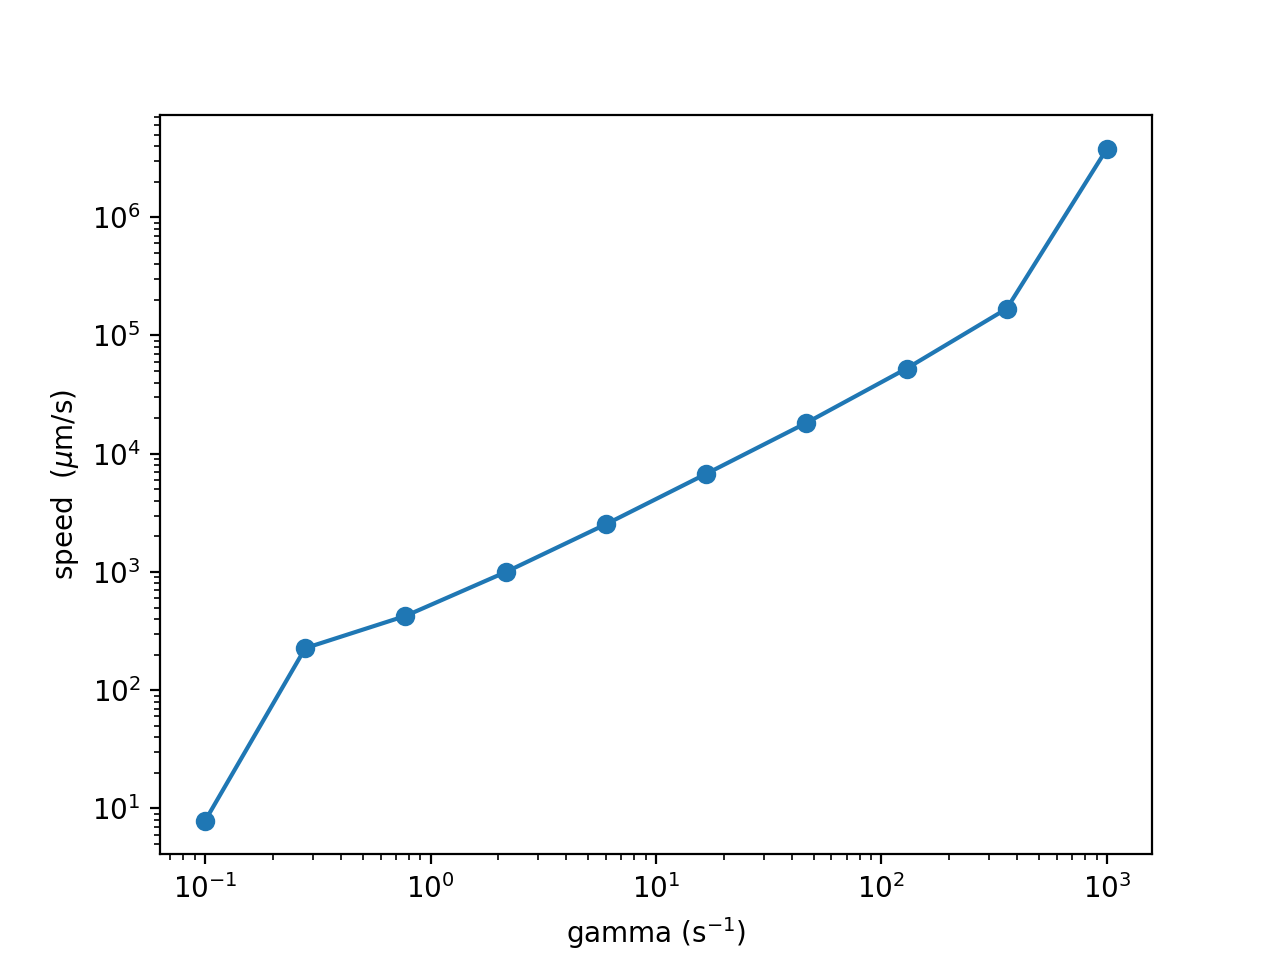

<IPython.core.display.Javascript object>


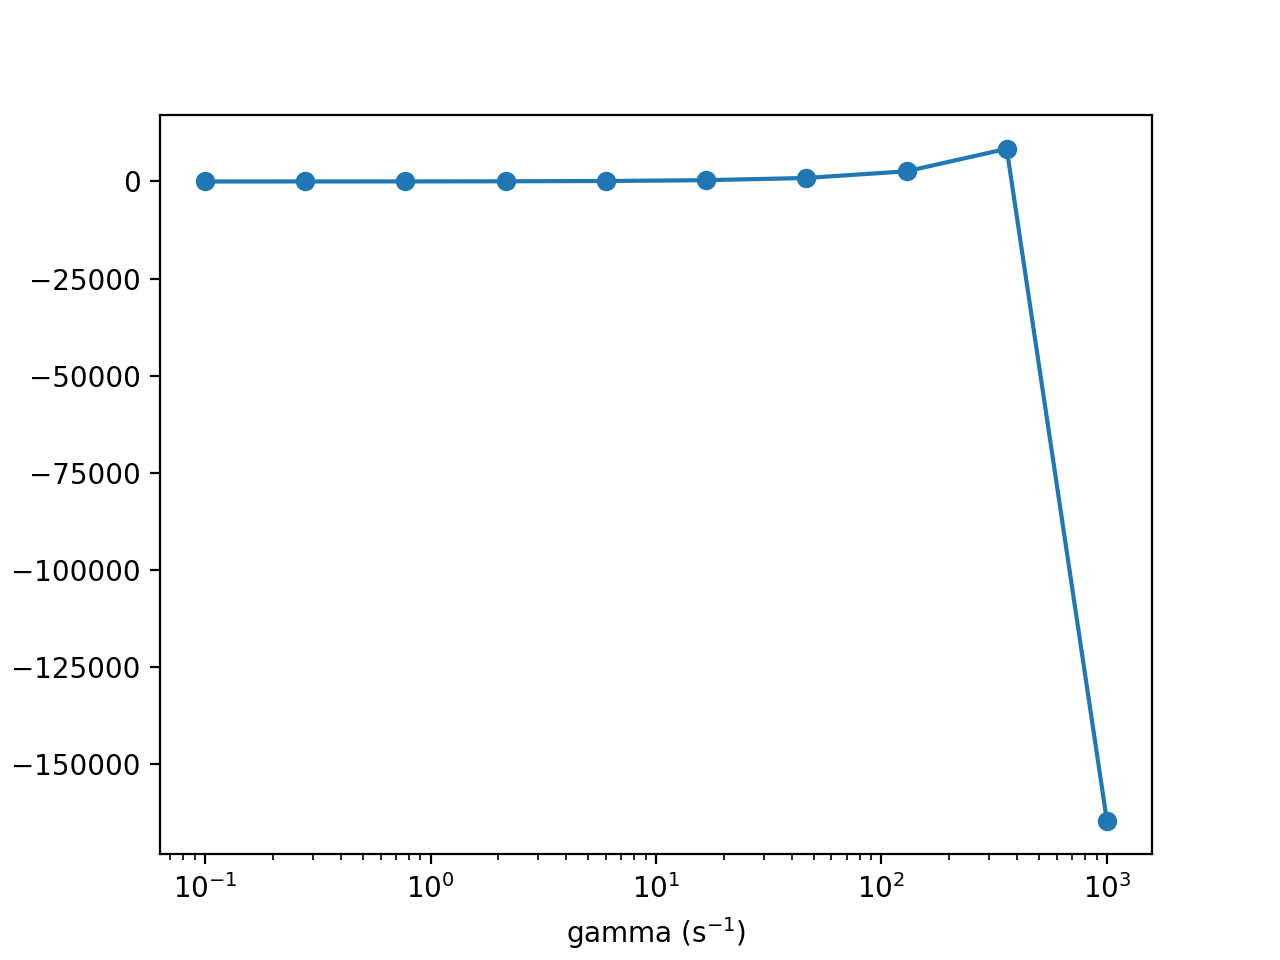

<IPython.core.display.Javascript object>


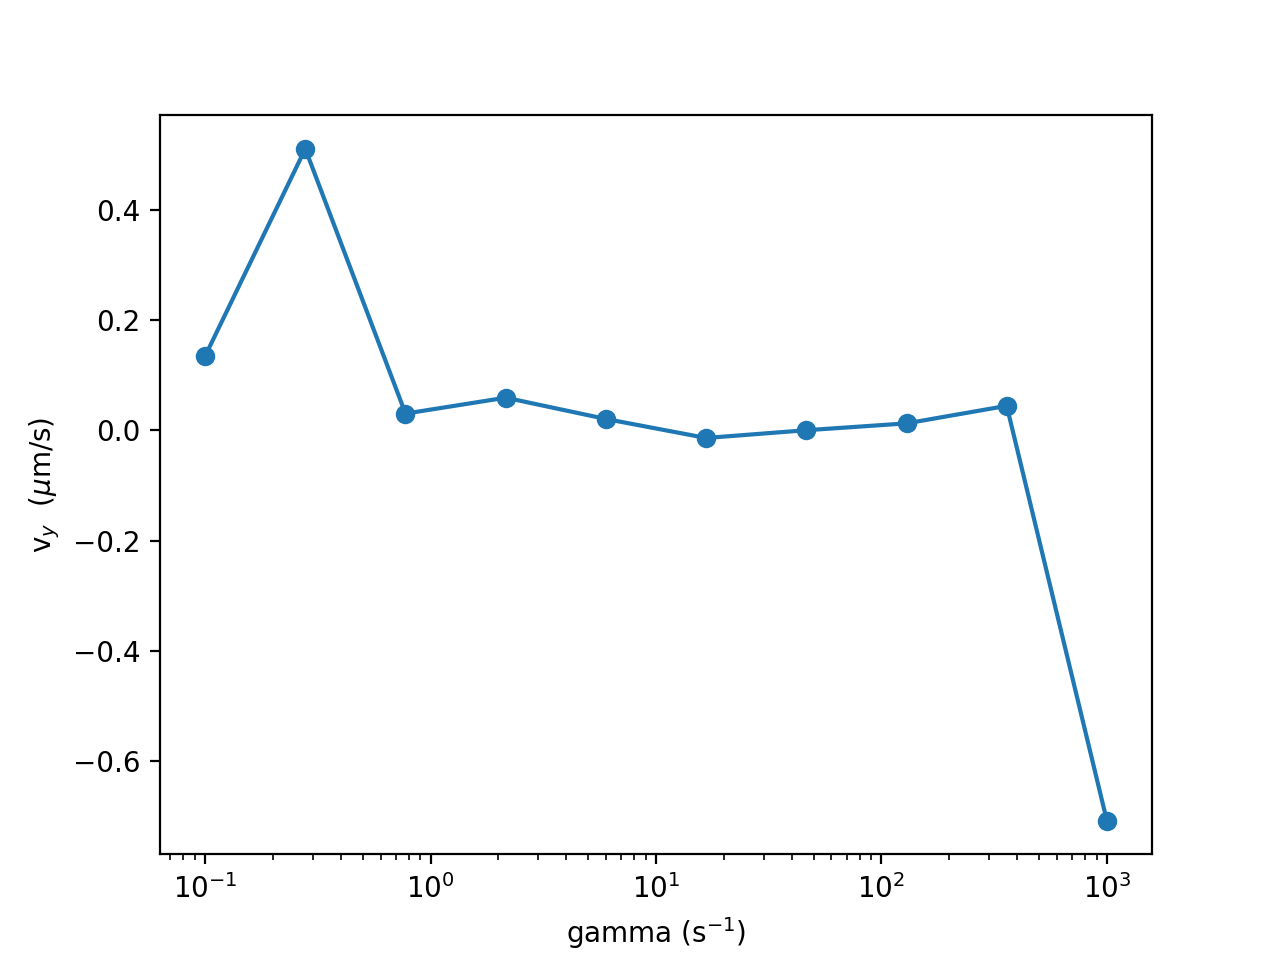

<IPython.core.display.Javascript object>


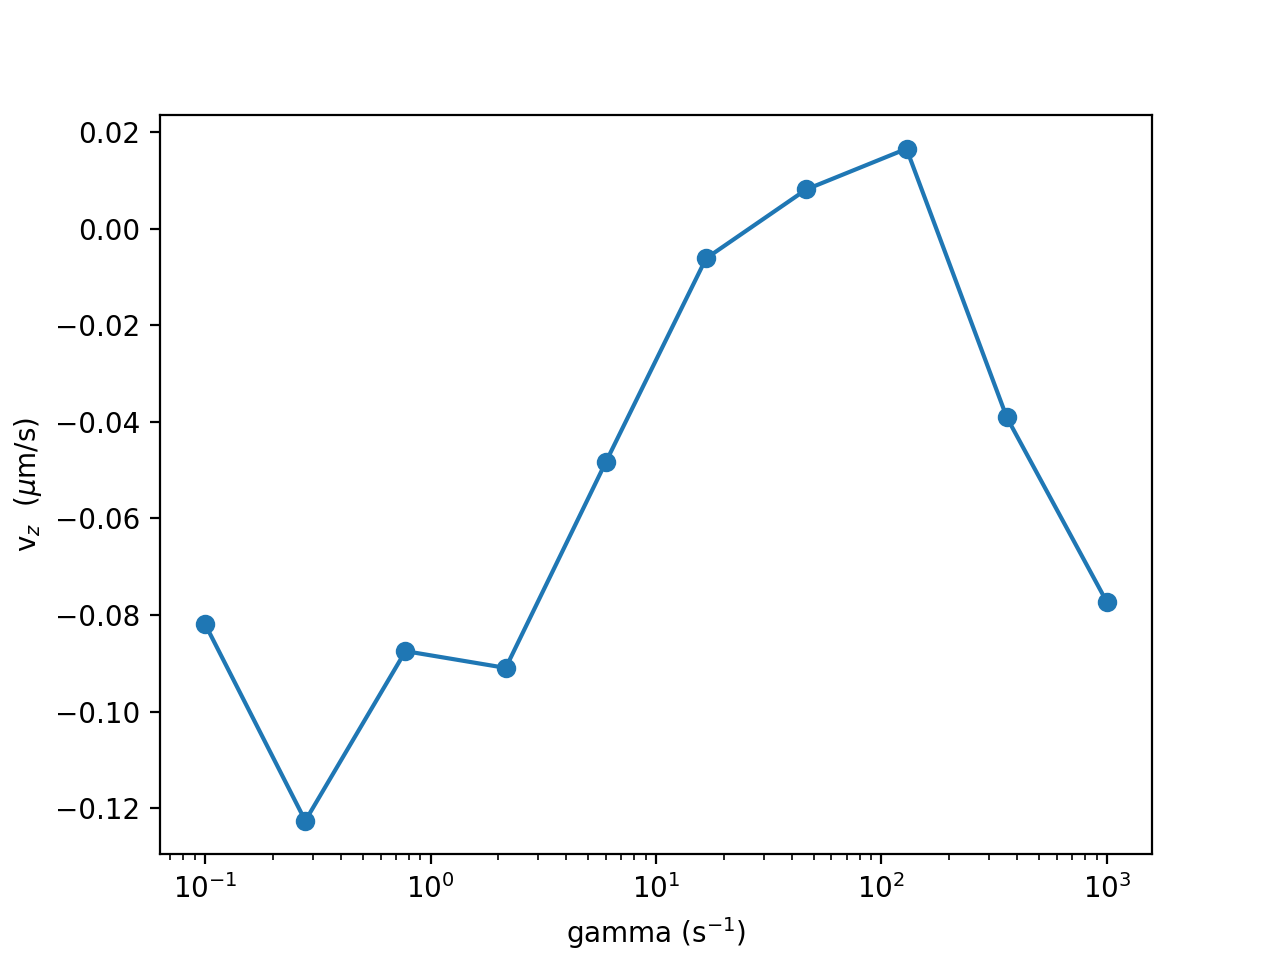

In [37]:
plt.figure()
plt.loglog(gammaVector, speedVec*1e6, 'o-')
plt.xlabel(r'gamma (s$^{-1}$)')
plt.ylabel(r'speed  ($\mu$m/s)')
#plt.ticklabel_format(style='sci', scilimits=(0,0))
plt.show()

plt.figure()
plt.semilogx(gammaVector, velocityAlongX*1e6, 'o-')
plt.xlabel(r'gamma (s$^{-1}$)')
plt.ylabel(r'v$_x$  ($\mu$m/s)')
#plt.ticklabel_format(style='sci', scilimits=(0,0))
plt.show()


plt.figure()
plt.semilogx(gammaVector, velocityAlongY*1e6, 'o-')
plt.xlabel(r'gamma (s$^{-1}$)')
plt.ylabel(r'v$_y$  ($\mu$m/s)')
#plt.ticklabel_format(style='sci', scilimits=(0,0))
plt.show()

plt.figure()
plt.semilogx(gammaVector, velocityAlongZ*1e6, 'o-')
plt.xlabel(r'gamma (s$^{-1}$)')
plt.ylabel(r'v$_z$  ($\mu$m/s)')
#plt.ticklabel_format(style='sci', scilimits=(0,0))
plt.show()

In [50]:
#plot3DTrajectory(centersData3)
plt.ioff()
for x in os.walk(basePath):
    currentDirectoryName = x[0]
    currentDirectoryPath = os.path.join(basePath, currentDirectoryName)
    files = os.listdir(currentDirectoryPath)
    for myFile in files:
        if 'trajectory' in myFile:
            fileFullPath = os.path.join(currentDirectoryPath, myFile)
            myData = np.loadtxt(fileFullPath)
            xVec = np.arange(np.shape(myData)[1])*dt*nSave
            figName = 'z.png'
            figPath = os.path.join(currentDirectoryPath, figName)
            fig = plt.figure()
            plt.plot(xVec, myData[2,:]*1e6)
            plt.xlabel('Time (s)')
            plt.ylabel('Position (um)')
            plt.title(myFile)
            plt.savefig(figPath)
            plt.close(fig)

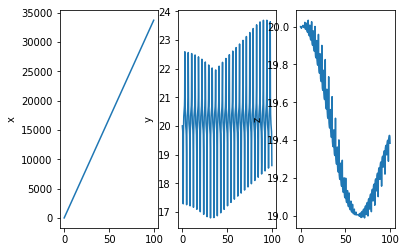

In [39]:
  
myData = np.loadtxt('/Users/gabriel/Documents/python/bacteria/bacteriaInSimpleFlows/bacteriaInShearResults/swimming/gamma1.00e-01/trajectory_gamma1.00e-01.txt')
myData = np.loadtxt('/Users/gabriel/Documents/python/bacteria/bacteriaInSimpleFlows/bacteriaInShearResults/swimming/gamma2.78e-01/trajectory_gamma2.78e-01.txt')
myData = np.loadtxt('/Users/gabriel/Documents/python/bacteria/bacteriaInSimpleFlows/bacteriaInShearResults/swimming/gamma2.15e+00/trajectory_gamma2.15e+00.txt')
myData = np.loadtxt('/Users/gabriel/Documents/python/bacteria/bacteriaInSimpleFlows/bacteriaInShearResults/swimming/gamma5.99e+00/trajectory_gamma5.99e+00.txt')
myData = np.loadtxt('/Users/gabriel/Documents/python/bacteria/bacteriaInSimpleFlows/bacteriaInShearResults/swimming/gamma1.67e+01/trajectory_gamma1.67e+01.txt')

#myData = np.loadtxt('/Users/gabriel/Documents/python/bacteria/bacteriaInSimpleFlows/bacteriaInShearResults/swimming/gamma4.64e+01/trajectory_gamma4.64e+01.txt')
#myData = np.loadtxt('/Users/gabriel/Documents/python/bacteria/bacteriaInSimpleFlows/bacteriaInShearResults/swimming/gamma1.00e+03/trajectory_gamma1.00e+03.txt')
#myData = np.loadtxt('/Users/gabriel/Documents/python/bacteria/bacteriaInSimpleFlows/bacteriaInShearResults/swimming/gamma1.29e+02/trajectory_gamma1.29e+02.txt')
#myData = np.loadtxt('/Users/gabriel/Documents/python/bacteria/bacteriaInSimpleFlows/bacteriaInShearResults/swimming/gamma3.59e+02/trajectory_gamma3.59e+02.txt')
plotComponentsOf3DTrajectory(myData*1e6, dt*nSave) #wRel = 0 and theta = np.pi
#plotEvolutionOfEulerAngles(orientationData3)

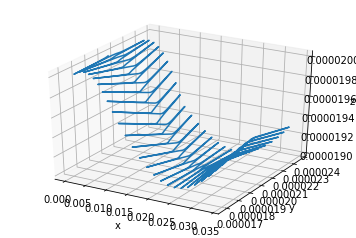

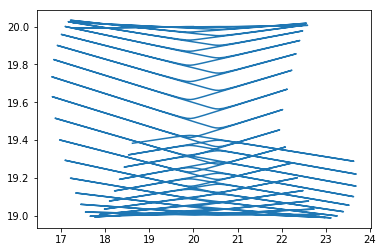

In [40]:
myData = np.loadtxt('/Users/gabriel/Documents/python/bacteria/bacteriaInSimpleFlows/bacteriaInShearResults/swimming/gamma1.67e+01/trajectory_gamma1.67e+01.txt')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(myData[0,:],myData[1,:],myData[2,:])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()


fig2 = plt.figure()
plt.plot(myData[1,:]*1e6,myData[2,:]*1e6)
plt.show()

In [27]:
np.linspace(myData[0,:])

(2500,)

<IPython.core.display.Javascript object>


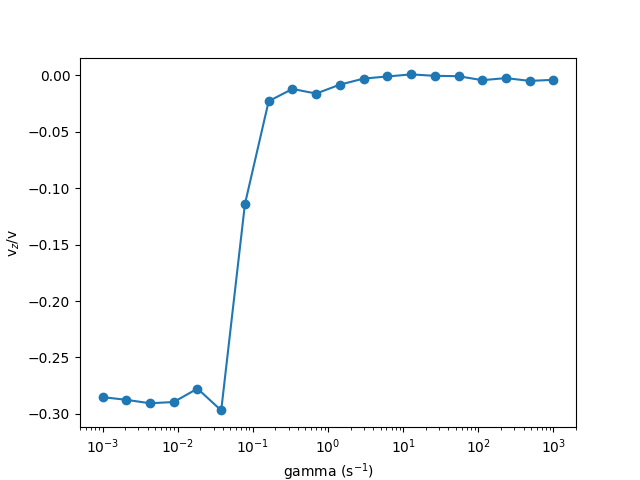

In [170]:
speedWithoutFlow= 4.76443853e+01*1e-6 #from the code freelySwimmingBacteria
plt.figure()
plt.semilogx(gammaVector, velocityAlongZ/speedWithoutFlow, 'o-')
plt.xlabel(r'gamma (s$^{-1}$)')
plt.ylabel(r'v$_z$/v')
#plt.ticklabel_format(style='sci', scilimits=(0,0))
plt.show()

<IPython.core.display.Javascript object>


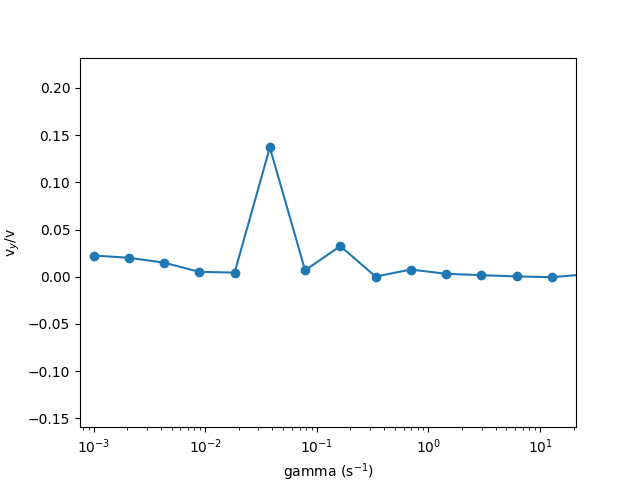

In [171]:
plt.figure()
plt.semilogx(gammaVector, velocityAlongY/speedWithoutFlow, 'o-')
plt.xlabel(r'gamma (s$^{-1}$)')
plt.ylabel(r'v$_y$/v')
#plt.ticklabel_format(style='sci', scilimits=(0,0))
plt.show()

<IPython.core.display.Javascript object>


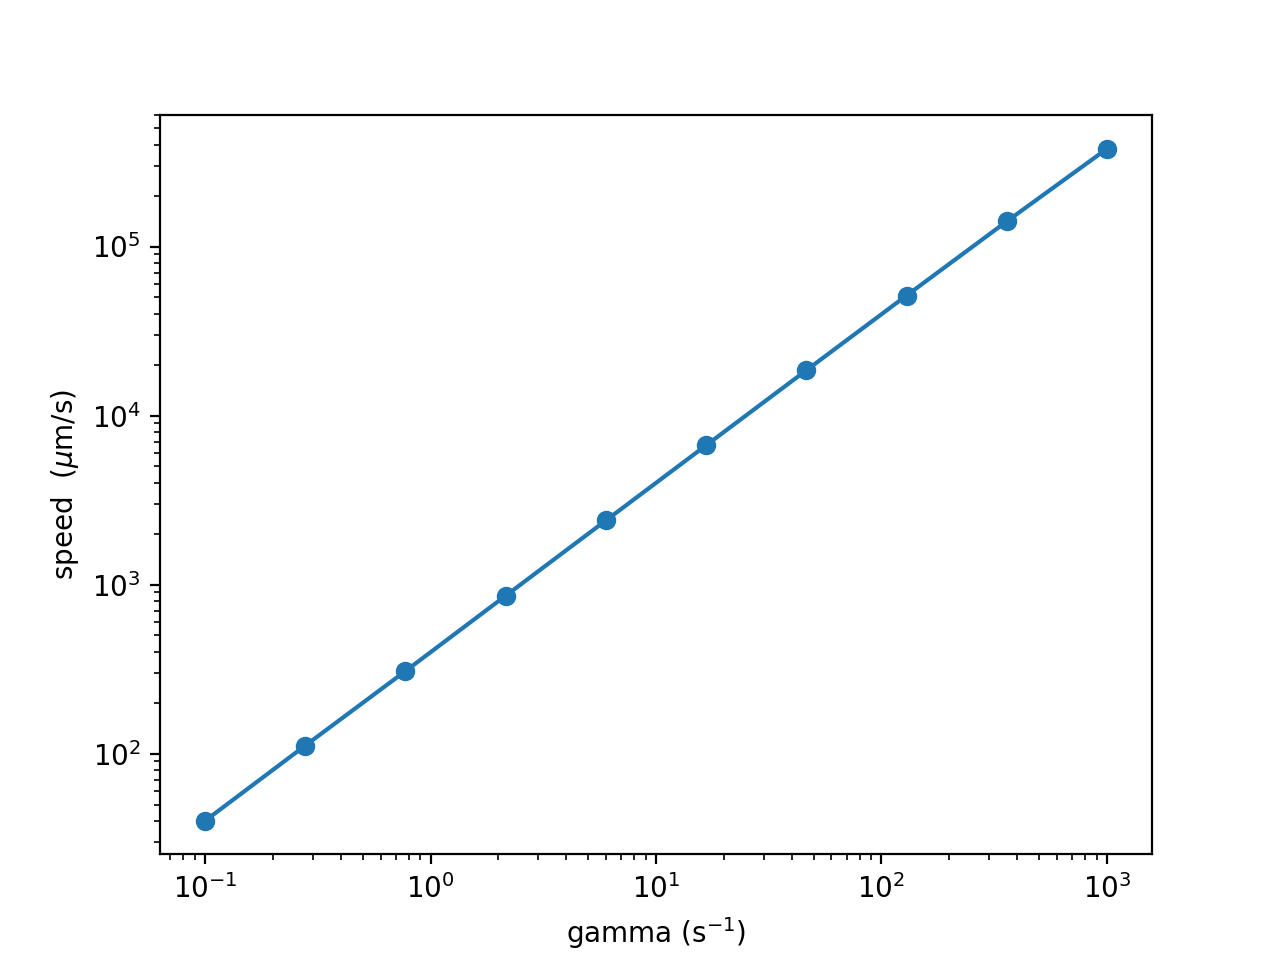

<IPython.core.display.Javascript object>


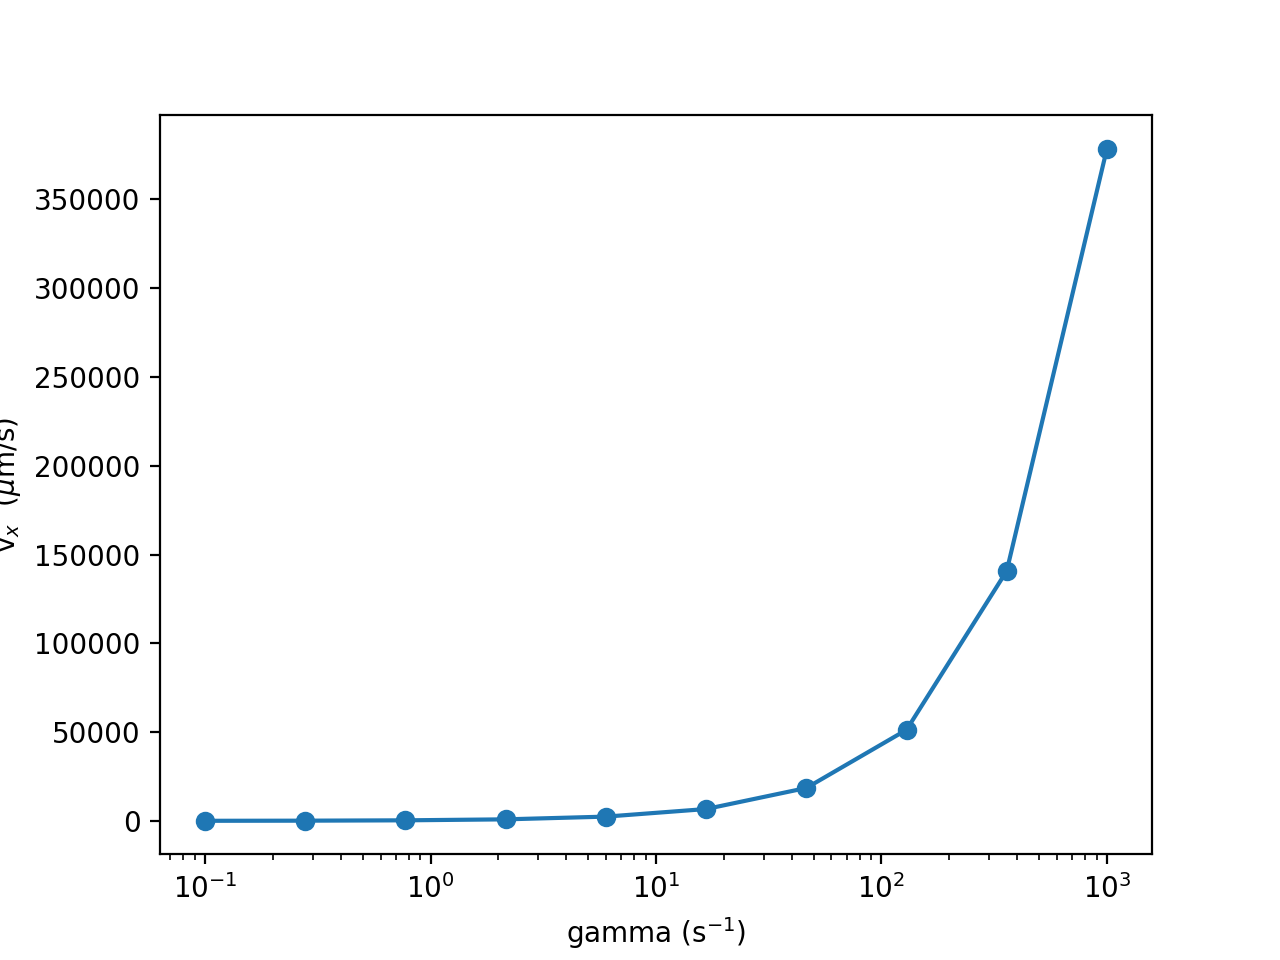

<IPython.core.display.Javascript object>


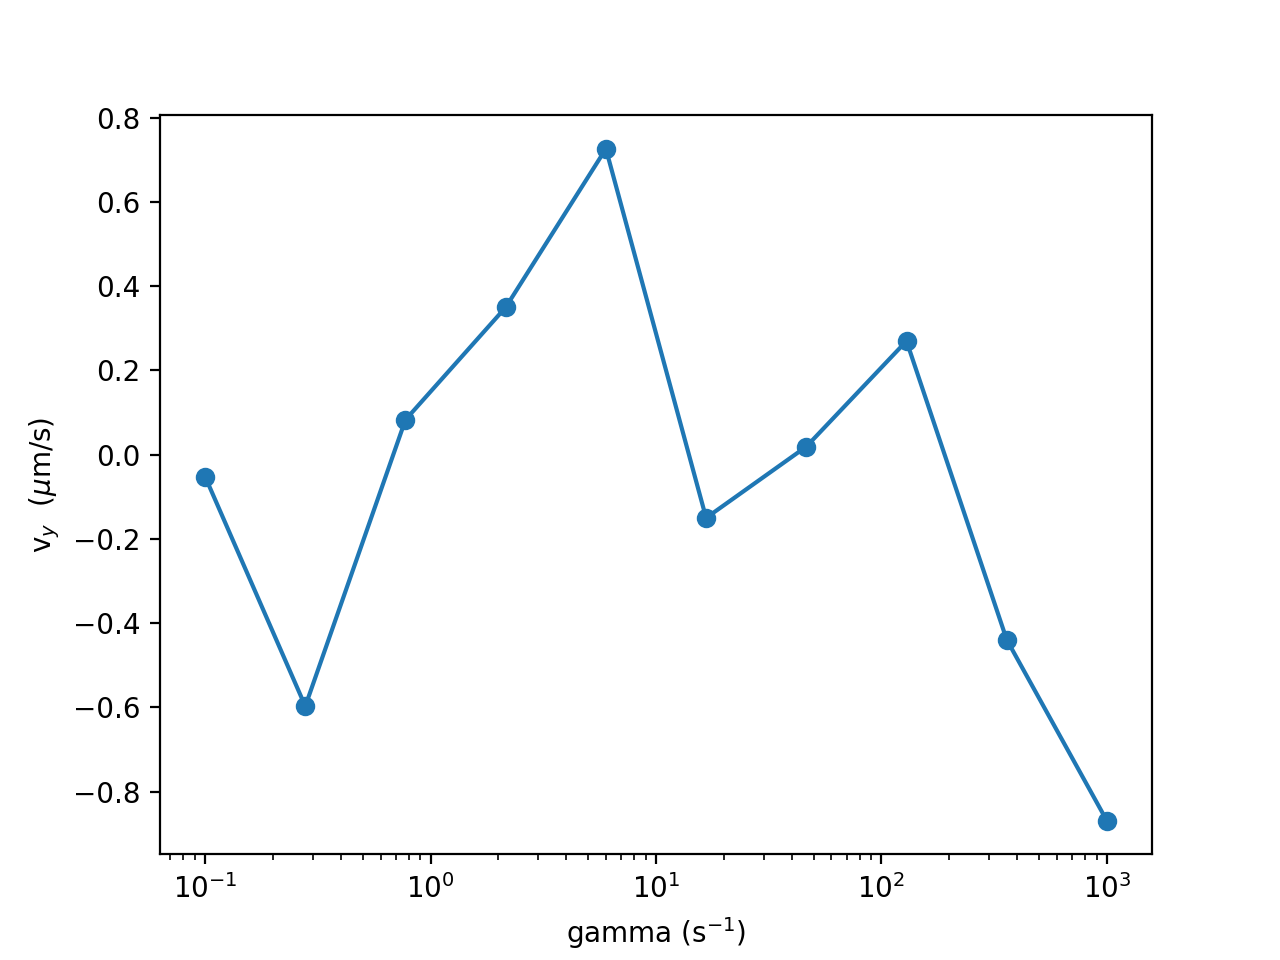

<IPython.core.display.Javascript object>


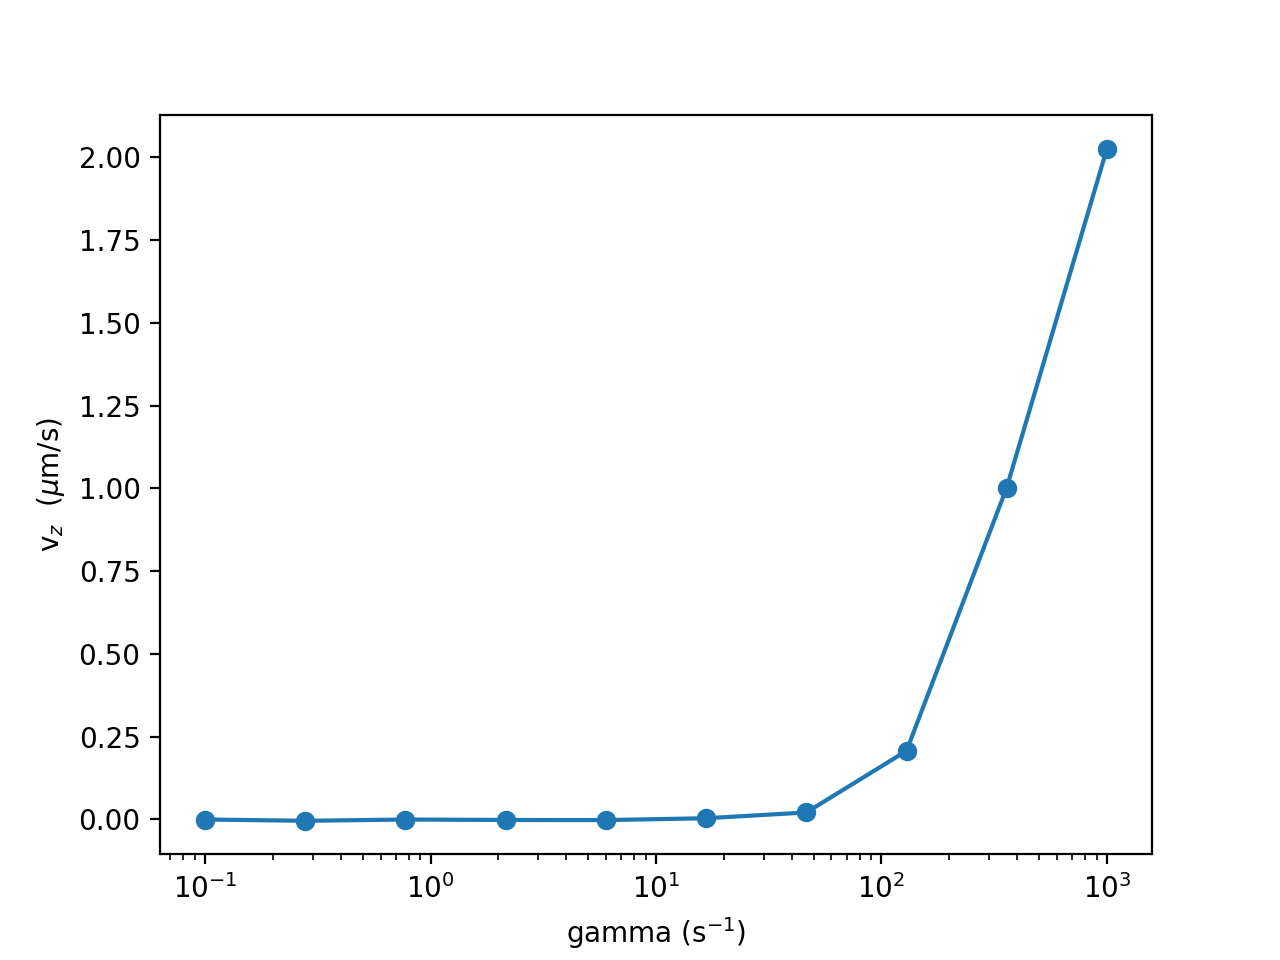

In [194]:
#currently the vectors hold the information for wRel = 0

plt.figure()
plt.loglog(gammaVector, speedVec*1e6, 'o-')
plt.xlabel(r'gamma (s$^{-1}$)')
plt.ylabel(r'speed  ($\mu$m/s)')
#plt.ticklabel_format(style='sci', scilimits=(0,0))
plt.show()

plt.figure()
plt.semilogx(gammaVector, velocityAlongX*1e6, 'o-')
plt.xlabel(r'gamma (s$^{-1}$)')
plt.ylabel(r'v$_x$  ($\mu$m/s)')
#plt.ticklabel_format(style='sci', scilimits=(0,0))
plt.show()


plt.figure()
plt.semilogx(gammaVector, velocityAlongY*1e6, 'o-')
plt.xlabel(r'gamma (s$^{-1}$)')
plt.ylabel(r'v$_y$  ($\mu$m/s)')
#plt.ticklabel_format(style='sci', scilimits=(0,0))
plt.show()

plt.figure()
plt.semilogx(gammaVector, velocityAlongZ*1e6, 'o-')
plt.xlabel(r'gamma (s$^{-1}$)')
plt.ylabel(r'v$_z$  ($\mu$m/s)')
#plt.ticklabel_format(style='sci', scilimits=(0,0))
plt.show()

<IPython.core.display.Javascript object>


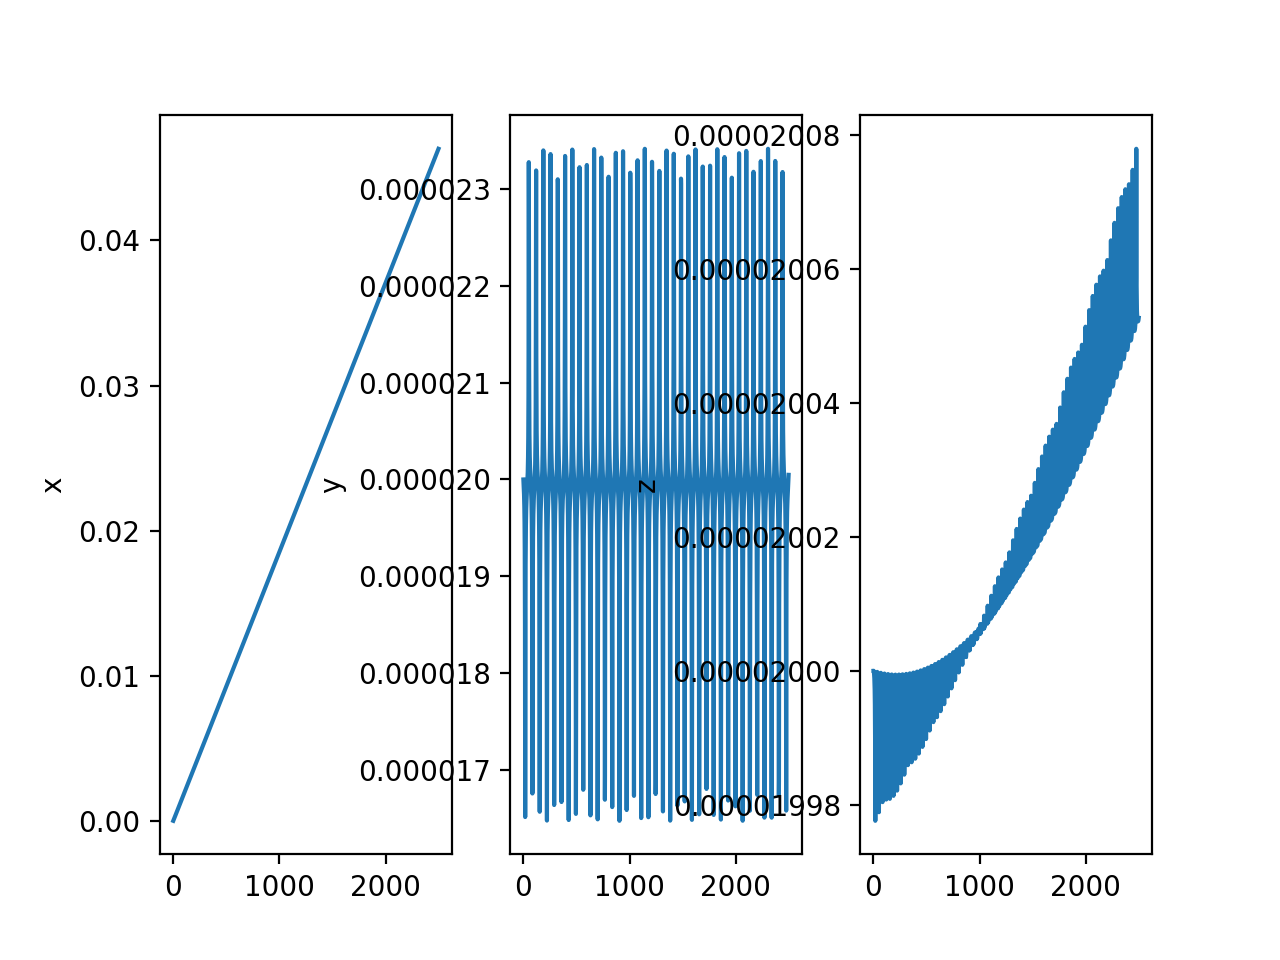

In [195]:
#plot3DTrajectory(centersData3)
myData = np.loadtxt('/Users/gabriel/Documents/python/bacteria/bacteriaInSimpleFlows/bacteriaInShearResults/nonSwimming/gamma4.64e+01/trajectory_gamma0.00e+00.txt')
plotComponentsOf3DTrajectory(myData) #wRel = 0 and theta = np.pi
#plotEvolutionOfEulerAngles(orientationData3)


<IPython.core.display.Javascript object>


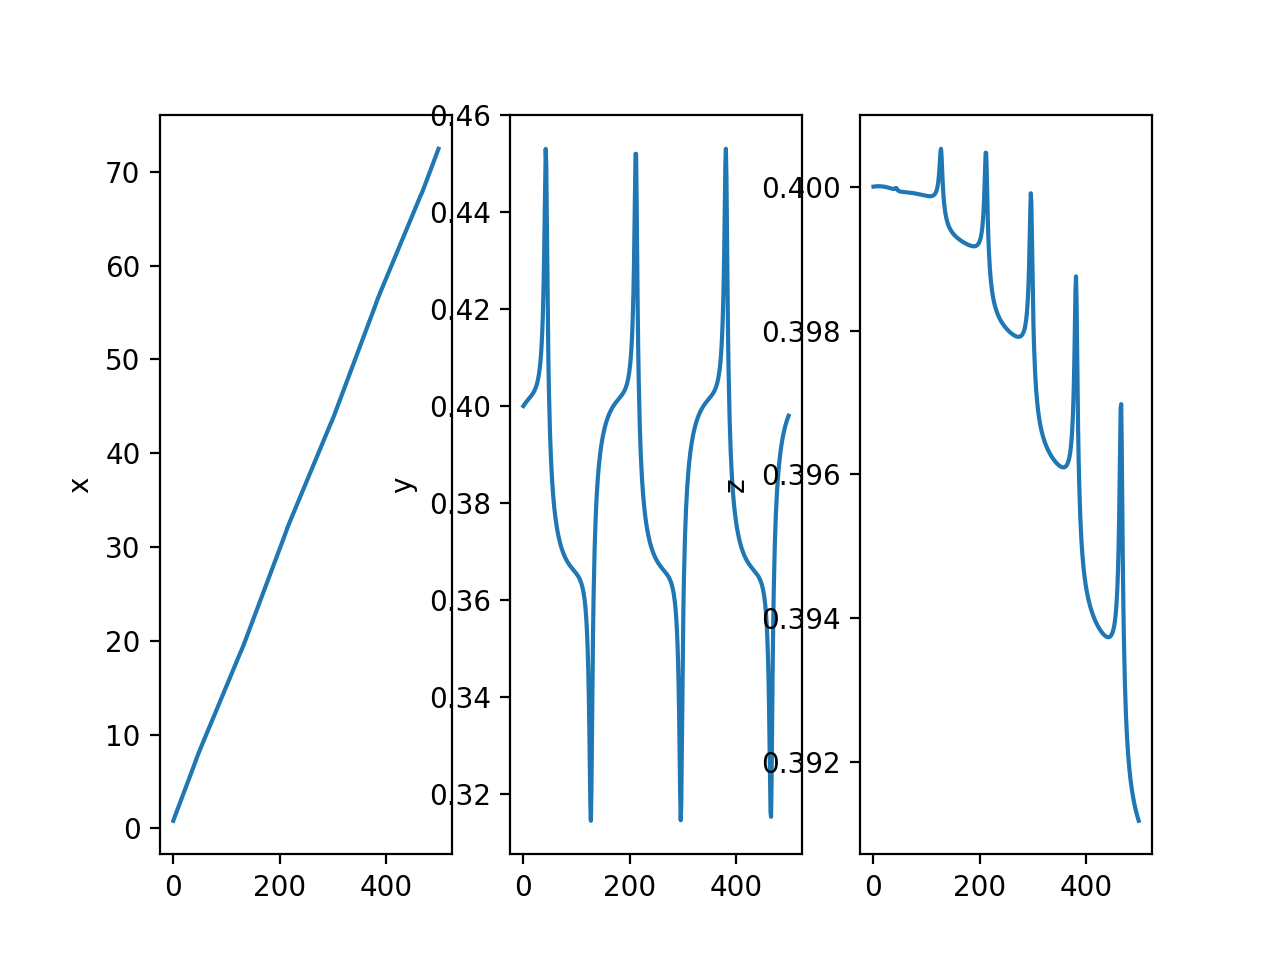

<IPython.core.display.Javascript object>


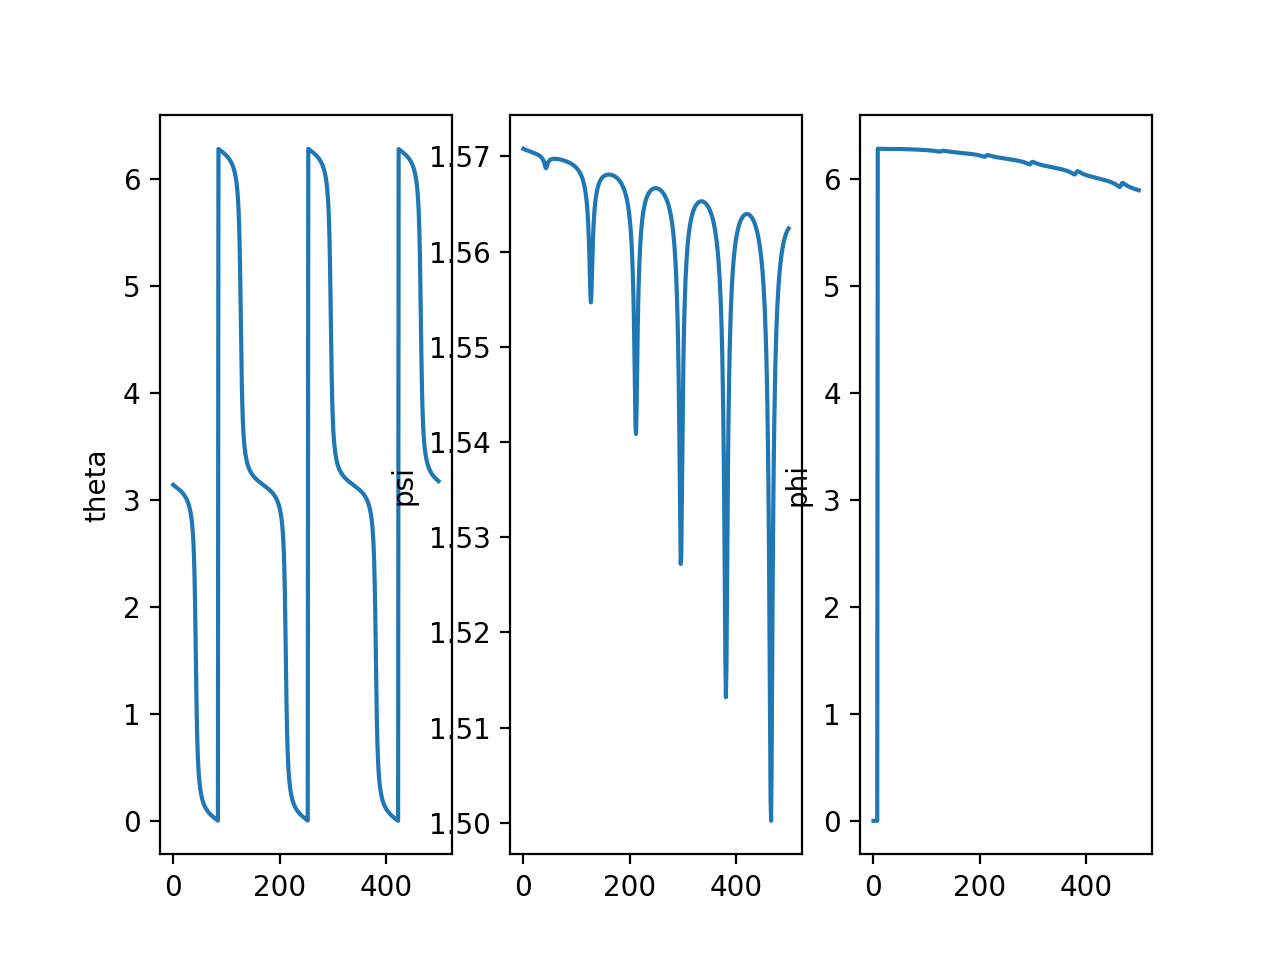

In [126]:
plotComponentsOf3DTrajectory(centersData2)
plotEvolutionOfEulerAngles(orientationData2) #wRel  = 100*2*np.pi et theta = np.pi

<IPython.core.display.Javascript object>


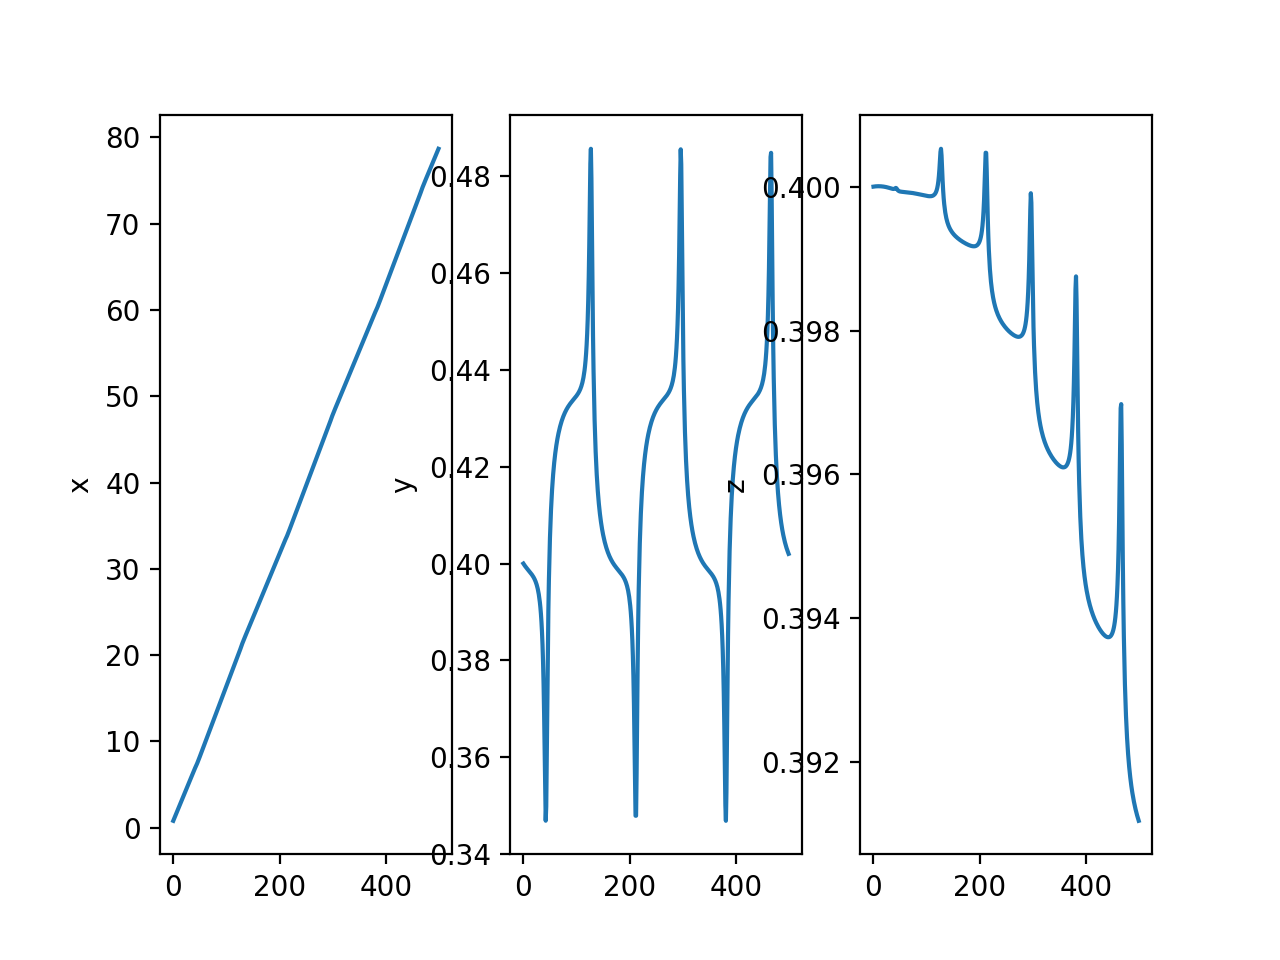

<IPython.core.display.Javascript object>


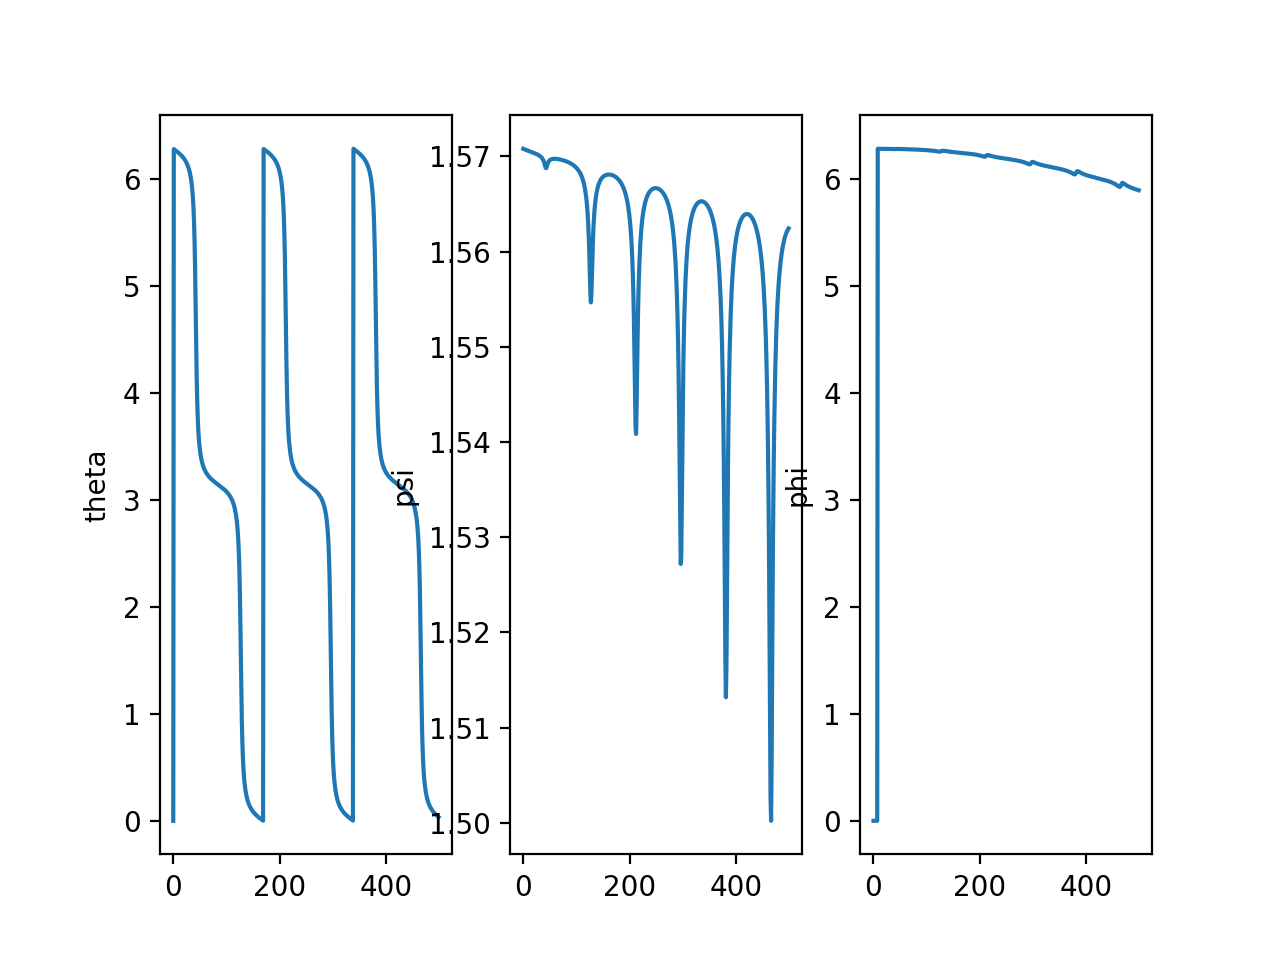

In [131]:
plotComponentsOf3DTrajectory(centersData1)
plotEvolutionOfEulerAngles(orientationData1) #wRel  = 100*2*np.pi et theta = 0